In [69]:
!pip install qiskit
!pip install tqdm
!pip install torchviz
!pip install qiskit-aer
!pip install qiskit_algorithms

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

import qiskit
from qiskit import Aer, QuantumRegister, QuantumCircuit as QiskitQuantumCircuit, ClassicalRegister, transpile, assemble
from qiskit.circuit import Parameter, ParameterVector
from qiskit.visualization import *


from scipy.optimize import minimize
from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image  # A library for image processing
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
# %matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from PIL import Image  # A library for image processing
%matplotlib inline

In [2]:
QC_outputs = ['0', '1']

In [3]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit.
    """

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.theta_0 = qiskit.circuit.Parameter('theta0')

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        
        self._circuit.ry(self.theta_0, 0)
        for i in range(n_qubits - 1):
            self._circuit.cnot(i, i + 1)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        # Convert to floats if necessary
        thetas = [float(theta.real) for theta in thetas]
        
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc, shots=self.shots, parameter_binds=[
            {self.theta_0: thetas[0]}
        ])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        states = np.array(list(result.keys())).astype(float)
        expects = np.zeros(2)
        resp = np.zeros(1)
        for k in range(2):
            key = QC_outputs[k]
            expe = result.get(key, 0)
            perc = expe / self.shots

            expects[k] = perc
            resp[0] += float(key) * perc
        return resp

In [4]:
#Going to test out the quantum circuit.
sim = qiskit.Aer.get_backend('qasm_simulator')

test_circuit = QuantumCircuit(1, sim, 100000)

In [5]:
#Heck yeah it works! It outputs the distributions of the outputs
test_circuit.run([1]), test_circuit._circuit.draw()   

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


(array([0.92114]),
         ┌───┐ ░ ┌────────────┐ ░ ┌─┐
      q: ┤ H ├─░─┤ Ry(theta0) ├─░─┤M├
         └───┘ ░ └────────────┘ ░ └╥┘
 meas: 1/══════════════════════════╩═
                                   0 )

In [6]:
def to_numbers(input):
    parameter = []

    #A very scrapy but functional way of loading the parameters in this format
    for x in input:
        for y in x:
            parameter.append(float(y.real))
    return parameter

In [8]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Convert input to float and ensure no complex values
        input_floats = [float(x) for x in to_numbers(input)]
        expectation_z = ctx.quantum_circuit.run(input_floats)
        #expectation_z = ctx.quantum_circuit.run(to_numbers(input))

        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = list(input)[0]

        gradients = torch.Tensor()

        for i in range(1):
            shift_right = np.array(input_list.detach().clone())
            shift_left = np.array(input_list.detach().clone())

            shift_right[i] = float(shift_right[i] + ctx.shift)
            shift_left[i] = float(shift_left[i] - ctx.shift)

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))

        gradients = gradients.T
        resp = gradients.float() * grad_output.float().T
        return resp, None, None


In [9]:
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, backend, shots, shift, n_qubits):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(n_qubits, backend, shots)
        self.quantum_circuit._circuit.draw()
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


In [10]:
class Net(nn.Module):
    def __init__(self, n_qubits):
        super(Net, self).__init__()
        # Definiendo todas las capas clásicas
        self.classical = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d()
        )
        
        # Definiendo la parte intermedia
        self.middel = nn.Sequential(
            nn.Linear(20 * 5 * 5, 500),  # Ajustar el tamaño del tensor adecuadamente
            nn.ReLU(),
            nn.Linear(500, n_qubits)
        )
        
        # Definiendo la parte cuántica
        self.quantum = Hybrid(Aer.get_backend('qasm_simulator'), 1000, np.pi / 2, n_qubits=n_qubits)
        
        # Definiendo la parte final de las capas clásicas
        self.end = nn.Sequential(
            nn.Linear(8, 5),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.classical(x)
        x = x.view(x.size(0), -1)  # Ajuste para el tamaño del batch
        
        # Pasar a través de la parte intermedia
        x = self.middel(x)
        
        # Pasar a través de la parte cuántica
        x = self.quantum(x)
        
        # Pasar a través de la parte final clásica
       # x = self.end(x.float())
        #x = x.view(1, -1)
        # Retornar la salida final
        return torch.cat((x, 1 - x), -1)
    
#learning sheduller, batch normalization, profundidad, LICyRELU

In [11]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust the image size as needed
    transforms.ToTensor()
])

# Load your custom dataset
custom_dataset = datasets.ImageFolder(root='C:/Users/Sergio/Documents/archive-20240617T011328Z-001/archive/Training', transform=transform)

# Extract labels and filter the dataset
labels = custom_dataset.targets
labels = np.array(labels)

# Specify the number of datapoints per class
n = 100

# Select indices for the two classes
idx_glioma = np.where(labels == 0)[0][:n]
idx_notumor = np.where(labels == 1)[0][:n]

# Concatenate the selected indices
selected_indices = np.concatenate((idx_glioma, idx_notumor))

# Update the dataset with the filtered labels and samples
custom_dataset.targets = labels[selected_indices]
custom_dataset.samples = [custom_dataset.samples[i] for i in selected_indices]

# Create a DataLoader for your dataset
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=1, shuffle=True)

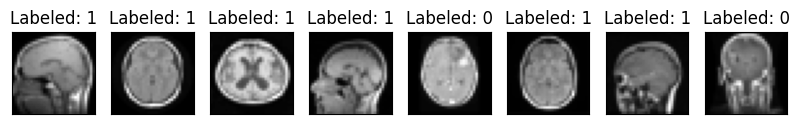

In [12]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))

    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1

In [13]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust the image size as needed
    transforms.ToTensor()
])

# Load your custom test dataset
custom_test_dataset = datasets.ImageFolder(root='C:/Users/Sergio/Documents/archive-20240617T011328Z-001/archive/Testing', transform=transform)

# Extract labels and filter the test dataset
labels = custom_test_dataset.targets
labels = np.array(labels)

# Specify the number of datapoints per class
n = 100

# Select indices for the two classes
idx_glioma = np.where(labels == 0)[0][:n]
idx_notumor = np.where(labels == 1)[0][:n]

# Concatenate the selected indices
selected_indices = np.concatenate((idx_glioma, idx_notumor))

# Update the test dataset with the filtered labels and samples
custom_test_dataset.targets = labels[selected_indices]
custom_test_dataset.samples = [custom_test_dataset.samples[i] for i in selected_indices]

# Create a DataLoader for your test dataset
test_loader = torch.utils.data.DataLoader(custom_test_dataset, batch_size=1, shuffle=True)

In [82]:
from qiskit_algorithms.optimizers import COBYLA
'''
def fitness_cost(parameters):
    # Refefencia a tu circuito cuantico
    qc = QuantumCircuit(3) # Llamar de algun lugar
    qc.set_parameters(parameters) #Buscar como se setean los parametros
    
    backend.run()
    job = backend.run().jobs()
    result = job.result()
    score = # Encontrar el valor esperado 
            # freq = {'01111':4, '11010':6}
            # acum = np.zeros(num_qubits)
            # sz = 0
            # for key,val in freq.items():
            #  sz += val
            #  for i,bin in enumerate(key):
            #    acum[i] += to_int(bin)
            # acum /= sz
            #
            # Verificar que tan bien le fue:
            # si el modelo fue pensado en encontrar la energia mímima
            #   se retorna el valor esperado
            # Caso contrario, me parece que, junto a parametros, se debe
            # colocar el valor deseado para comparlo con el esperado
    return score
 
    optimizer = COBYLA(maxiter=100)
    model_ = optimizer.minimize(fun=fitness_cost, x0=[0]*3 )
    print(model_)
    print("Best values:", model_.x)
    exit()
    '''

'\ndef fitness_cost(parameters):\n    # Refefencia a tu circuito cuantico\n    qc = QuantumCircuit(3) # Llamar de algun lugar\n    qc.set_parameters(parameters) #Buscar como se setean los parametros\n    \n    backend.run()\n    job = backend.run().jobs()\n    result = job.result()\n    score = # Encontrar el valor esperado \n            # freq = {\'01111\':4, \'11010\':6}\n            # acum = np.zeros(num_qubits)\n            # sz = 0\n            # for key,val in freq.items():\n            #  sz += val\n            #  for i,bin in enumerate(key):\n            #    acum[i] += to_int(bin)\n            # acum /= sz\n            #\n            # Verificar que tan bien le fue:\n            # si el modelo fue pensado en encontrar la energia mímima\n            #   se retorna el valor esperado\n            # Caso contrario, me parece que, junto a parametros, se debe\n            # colocar el valor deseado para comparlo con el esperado\n    return score\n \n    optimizer = COBYLA(maxiter=10

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\2285168774.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  result = torch.tensor([expectation_z])


Epoch [1/5]	Training [20%]	Loss: 0.6820
Epoch [1/5]	Validation	Loss: 0.6452	Validation Accuracy: 52.5%
Epoch [2/5]	Training [40%]	Loss: 0.6313
Epoch [2/5]	Validation	Loss: 0.5637	Validation Accuracy: 87.0%
Epoch [3/5]	Training [60%]	Loss: 0.5651
Epoch [3/5]	Validation	Loss: 0.5060	Validation Accuracy: 81.5%
Epoch [4/5]	Training [80%]	Loss: 0.5196
Epoch [4/5]	Validation	Loss: 0.4633	Validation Accuracy: 85.5%
Epoch [5/5]	Training [100%]	Loss: 0.5407
Epoch [5/5]	Validation	Loss: 0.4845	Validation Accuracy: 82.5%
Rendimiento del test data:
	Loss: 0.4845
	Accuracy: 82.5%
	precision: 87.0%
	recall: 82.5%
	f_score: 81.9%
(0.8703703703703703, 0.825, 0.819471308833011, None)

Confusion Matrix:
[[100   0]
 [ 35  65]]


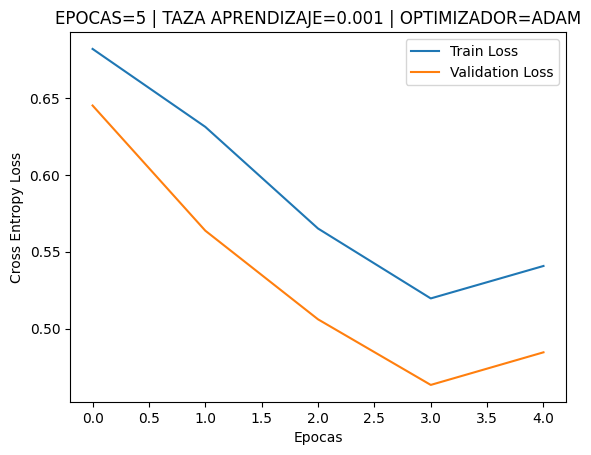

In [14]:
model = Net(n_qubits = 1)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training

    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        #minimize()
        
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))
    

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Rendimiento del test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.7290
Epoch [1/5]	Validation	Loss: 0.6836	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.7133
Epoch [2/5]	Validation	Loss: 0.6933	Validation Accuracy: 50.0%
Epoch [3/5]	Training [60%]	Loss: 0.6984
Epoch [3/5]	Validation	Loss: 0.6215	Validation Accuracy: 79.0%
Epoch [4/5]	Training [80%]	Loss: 0.6754
Epoch [4/5]	Validation	Loss: 0.6990	Validation Accuracy: 50.0%
Epoch [5/5]	Training [100%]	Loss: 0.6968
Epoch [5/5]	Validation	Loss: 0.6930	Validation Accuracy: 52.0%
Rendimiento del test data:
	Loss: 0.6930
	Accuracy: 52.0%
	precision: 67.2%
	recall: 52.0%
	f_score: 38.4%
(0.6718213058419245, 0.52, 0.3839045051983057, None)

Confusion Matrix:
[[99  1]
 [95  5]]


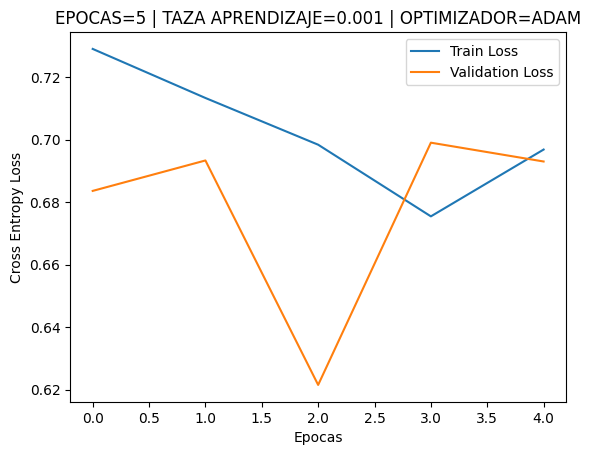

In [15]:
model = Net(n_qubits = 1)

optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training

    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        #minimize()
        
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))
    

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Rendimiento del test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


In [16]:
num_qubits = 1

**Ahora entrenemos la red**

We can specify any PyTorch optimiser (here we use the Adam optimiser), learning rate and cost/loss function in order to train over multiple epochs. In this instance, we use  a learning rate of 0.001 and the negative log-likelihood loss function.
We then plot the training graph. We do this for 5, 10, 20, 30 epochs

--------------------------------EMPEZAMOSS----------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6992
Epoch [1/5]	Validation	Loss: 0.6625	Validation Accuracy: 54.5%
Epoch [2/5]	Training [40%]	Loss: 0.6230
Epoch [2/5]	Validation	Loss: 0.6217	Validation Accuracy: 67.0%
Epoch [3/5]	Training [60%]	Loss: 0.5911
Epoch [3/5]	Validation	Loss: 0.5564	Validation Accuracy: 82.0%
Epoch [4/5]	Training [80%]	Loss: 0.5678
Epoch [4/5]	Validation	Loss: 0.5309	Validation Accuracy: 81.0%
Epoch [5/5]	Training [100%]	Loss: 0.5209
Epoch [5/5]	Validation	Loss: 0.5037	Validation Accuracy: 81.0%
Performance on the test data:
	Loss: 0.5037
	Accuracy: 81.0%
	precision: 86.2%
	recall: 81.0%
	f_score: 80.3%
(0.8623188405797102, 0.81, 0.8028841166096068, None)

Confusion Matrix:
[[100   0]
 [ 38  62]]


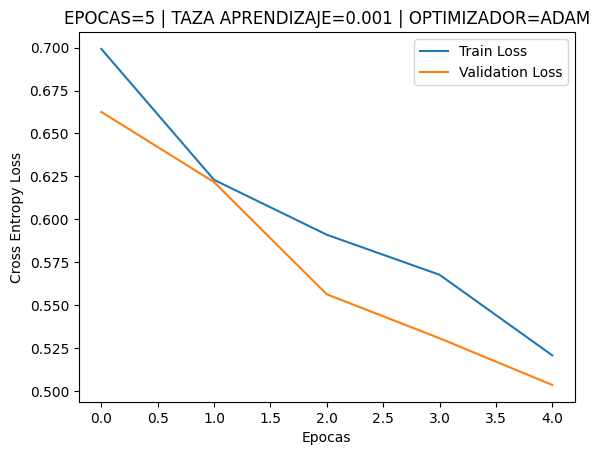

In [17]:
model = Net(n_qubits = 1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


EPOCHS=10, LEARNING RATE=0.001, OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6888
Epoch [1/10]	Validation	Loss: 0.6703	Validation Accuracy: 50.5%
Epoch [2/10]	Training [20%]	Loss: 0.5829
Epoch [2/10]	Validation	Loss: 0.5203	Validation Accuracy: 85.0%
Epoch [3/10]	Training [30%]	Loss: 0.5695
Epoch [3/10]	Validation	Loss: 0.5383	Validation Accuracy: 76.5%
Epoch [4/10]	Training [40%]	Loss: 0.5209
Epoch [4/10]	Validation	Loss: 0.5537	Validation Accuracy: 75.5%
Epoch [5/10]	Training [50%]	Loss: 0.5201
Epoch [5/10]	Validation	Loss: 0.5510	Validation Accuracy: 76.5%
Epoch [6/10]	Training [60%]	Loss: 0.4969
Epoch [6/10]	Validation	Loss: 0.5484	Validation Accuracy: 76.0%
Epoch [7/10]	Training [70%]	Loss: 0.4922
Epoch [7/10]	Validation	Loss: 0.5079	Validation Accuracy: 80.0%
Epoch [8/10]	Training [80%]	Loss: 0.4748
Epoch [8/10]	Validation	Loss: 0.5211	Validation Accuracy: 78.0%
Epoch [9/10]	Training [90%]	Loss: 0.4455
Epoch [9/10]	Validation	Loss: 0.4983	Validation Accuracy: 80.0%
Epoch [10/10]	Training [100%]	Loss: 0.4498
Epoch [10/10

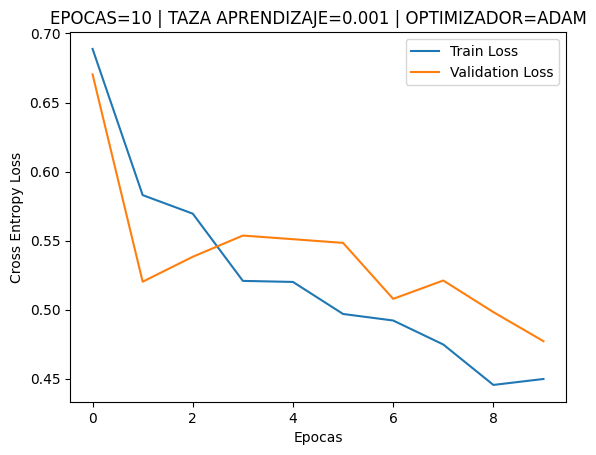

In [18]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6933
Epoch [1/15]	Validation	Loss: 0.6198	Validation Accuracy: 76.0%
Epoch [2/15]	Training [13%]	Loss: 0.5903
Epoch [2/15]	Validation	Loss: 0.6840	Validation Accuracy: 56.0%
Epoch [3/15]	Training [20%]	Loss: 0.5431
Epoch [3/15]	Validation	Loss: 0.4815	Validation Accuracy: 83.0%
Epoch [4/15]	Training [27%]	Loss: 0.5477
Epoch [4/15]	Validation	Loss: 0.6512	Validation Accuracy: 62.5%
Epoch [5/15]	Training [33%]	Loss: 0.7823
Epoch [5/15]	Validation	Loss: 0.7381	Validation Accuracy: 48.5%
Epoch [6/15]	Training [40%]	Loss: 0.7379
Epoch [6/15]	Validation	Loss: 0.7213	Validation Accuracy: 54.0%
Epoch [7/15]	Training [47%]	Loss: 0.7566
Epoch [7/15]	Validation	Loss: 0.7662	Validation Accuracy: 48.5%
Epoch [8/15]	Training [53%]	Loss: 0.7403
Epoch [8/15]	Validation	Loss: 0.7721	Validation Accuracy: 51.0%
Epoch [9/15]	Training [60%]	Loss: 0.7783
Epoch [9/15]	Validation	Loss: 0.7310	Validation Accuracy: 56.0%
Epoch [10/15]	Training [67%]	Loss: 0.7629
Epoch [10/15]	

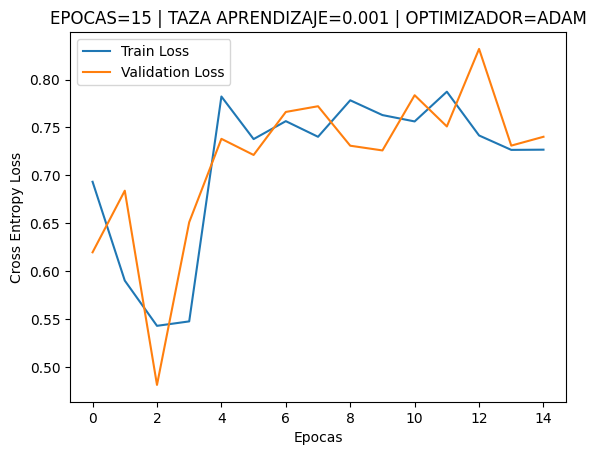

In [19]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6805
Epoch [1/20]	Validation	Loss: 0.6083	Validation Accuracy: 81.0%
Epoch [2/20]	Training [10%]	Loss: 0.6217
Epoch [2/20]	Validation	Loss: 0.4930	Validation Accuracy: 84.0%
Epoch [3/20]	Training [15%]	Loss: 0.5737
Epoch [3/20]	Validation	Loss: 0.5636	Validation Accuracy: 77.5%
Epoch [4/20]	Training [20%]	Loss: 0.5448
Epoch [4/20]	Validation	Loss: 0.4719	Validation Accuracy: 84.5%
Epoch [5/20]	Training [25%]	Loss: 0.5250
Epoch [5/20]	Validation	Loss: 0.4830	Validation Accuracy: 83.0%
Epoch [6/20]	Training [30%]	Loss: 0.5114
Epoch [6/20]	Validation	Loss: 0.5035	Validation Accuracy: 84.5%
Epoch [7/20]	Training [35%]	Loss: 0.4993
Epoch [7/20]	Validation	Loss: 0.4922	Validation Accuracy: 80.0%
Epoch [8/20]	Training [40%]	Loss: 0.4729
Epoch [8/20]	Validation	Loss: 0.4922	Validation Accuracy: 81.0%
Epoch [9/20]	Training [45%]	Loss: 0.4557
Epoch [9/20]	Validation	Loss: 0.4294	Validation Accuracy: 88.5%
Epoch [10/20]	Training [50%]	Loss: 0.4369
Epoch [10/20]	

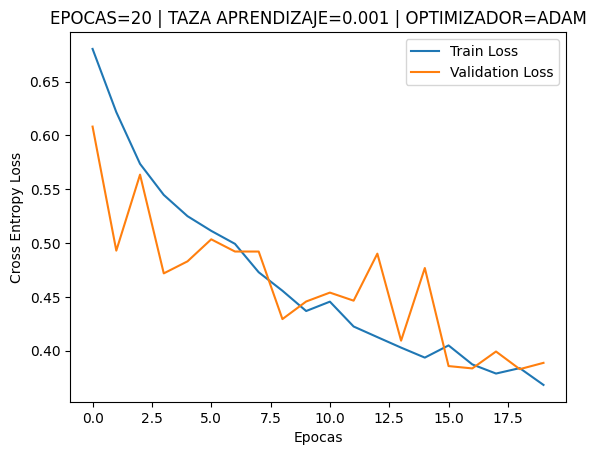

In [20]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=30 | LEARNING RATE=0.001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/30]	Training [3%]	Loss: 0.6910
Epoch [1/30]	Validation	Loss: 0.6898	Validation Accuracy: 50.0%
Epoch [2/30]	Training [7%]	Loss: 0.6436
Epoch [2/30]	Validation	Loss: 0.7232	Validation Accuracy: 55.5%
Epoch [3/30]	Training [10%]	Loss: 0.6485
Epoch [3/30]	Validation	Loss: 0.5539	Validation Accuracy: 76.5%
Epoch [4/30]	Training [13%]	Loss: 0.5724
Epoch [4/30]	Validation	Loss: 0.5469	Validation Accuracy: 82.5%
Epoch [5/30]	Training [17%]	Loss: 0.6321
Epoch [5/30]	Validation	Loss: 0.5566	Validation Accuracy: 85.5%
Epoch [6/30]	Training [20%]	Loss: 0.5528
Epoch [6/30]	Validation	Loss: 0.5663	Validation Accuracy: 75.5%
Epoch [7/30]	Training [23%]	Loss: 0.5638
Epoch [7/30]	Validation	Loss: 0.5995	Validation Accuracy: 82.5%
Epoch [8/30]	Training [27%]	Loss: 0.5463
Epoch [8/30]	Validation	Loss: 0.5441	Validation Accuracy: 78.5%
Epoch [9/30]	Training [30%]	Loss: 0.5400
Epoch [9/30]	Validation	Loss: 0.5559	Validation Accuracy: 78.5%
Epoch [10/30]	Training [33%]	Loss: 0.5213
Epoch [10/30]	V

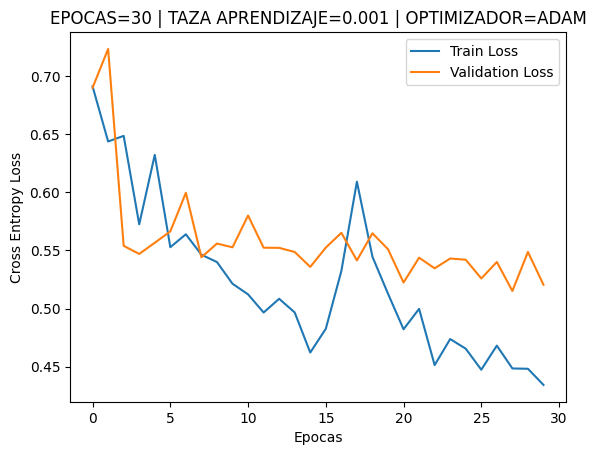

In [21]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 30
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=30 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 *******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.7352
Epoch [1/5]	Validation	Loss: 0.7582	Validation Accuracy: 52.0%
Epoch [2/5]	Training [40%]	Loss: 0.7602
Epoch [2/5]	Validation	Loss: 0.8028	Validation Accuracy: 46.0%
Epoch [3/5]	Training [60%]	Loss: 0.7117
Epoch [3/5]	Validation	Loss: 0.7232	Validation Accuracy: 53.5%
Epoch [4/5]	Training [80%]	Loss: 0.7112
Epoch [4/5]	Validation	Loss: 0.7540	Validation Accuracy: 52.5%
Epoch [5/5]	Training [100%]	Loss: 0.7385
Epoch [5/5]	Validation	Loss: 0.8478	Validation Accuracy: 41.5%
Performance on the test data:
	Loss: 0.8478
	Accuracy: 41.5%
	precision: 41.5%
	recall: 41.5%
	f_score: 41.4%
(0.4145814491005929, 0.41500000000000004, 0.41428249605767065, None)

Confusion Matrix:
[[45 55]
 [62 38]]


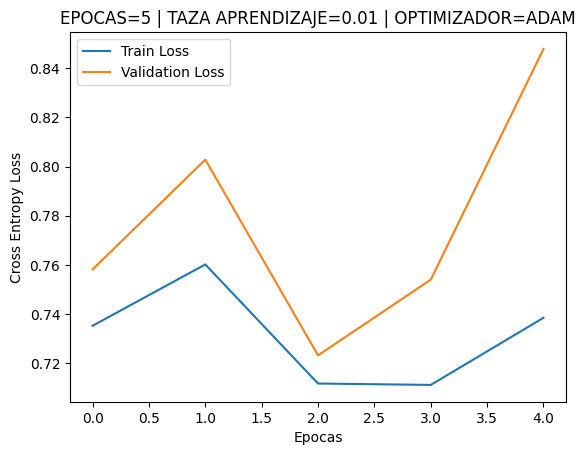

In [22]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.7435
Epoch [1/10]	Validation	Loss: 0.7250	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 0.7670
Epoch [2/10]	Validation	Loss: 0.8008	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 0.7338
Epoch [3/10]	Validation	Loss: 0.6938	Validation Accuracy: 47.0%
Epoch [4/10]	Training [40%]	Loss: 0.6993
Epoch [4/10]	Validation	Loss: 0.6935	Validation Accuracy: 49.5%
Epoch [5/10]	Training [50%]	Loss: 0.7025
Epoch [5/10]	Validation	Loss: 0.6928	Validation Accuracy: 47.0%
Epoch [6/10]	Training [60%]	Loss: 0.6959
Epoch [6/10]	Validation	Loss: 0.6935	Validation Accuracy: 49.5%
Epoch [7/10]	Training [70%]	Loss: 0.6915
Epoch [7/10]	Validation	Loss: 0.6946	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 0.6960
Epoch [8/10]	Validation	Loss: 0.6944	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 0.6964
Epoch [9/10]	Validation	Loss: 0.6936	Validation Accuracy: 49.5%
Epoch [10/10]	Training [100%]	Loss: 0.6956
Epoch [10/10

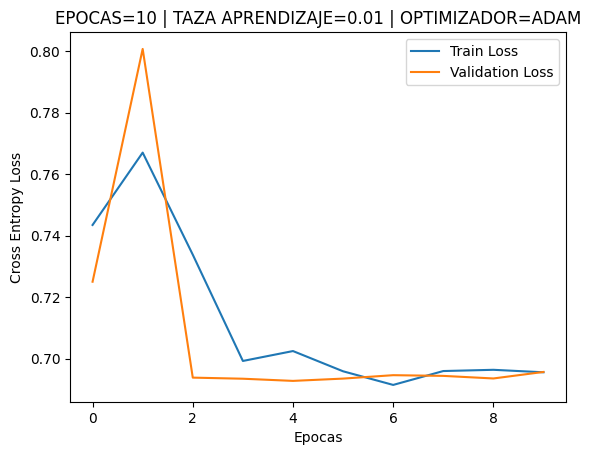

In [23]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.7055
Epoch [1/15]	Validation	Loss: 0.6930	Validation Accuracy: 53.0%
Epoch [2/15]	Training [13%]	Loss: 0.6951
Epoch [2/15]	Validation	Loss: 0.6921	Validation Accuracy: 51.0%
Epoch [3/15]	Training [20%]	Loss: 0.6958
Epoch [3/15]	Validation	Loss: 0.6939	Validation Accuracy: 49.5%
Epoch [4/15]	Training [27%]	Loss: 0.6951
Epoch [4/15]	Validation	Loss: 0.6914	Validation Accuracy: 54.5%
Epoch [5/15]	Training [33%]	Loss: 0.6959
Epoch [5/15]	Validation	Loss: 0.6927	Validation Accuracy: 49.0%
Epoch [6/15]	Training [40%]	Loss: 0.6981
Epoch [6/15]	Validation	Loss: 0.6941	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 0.6964
Epoch [7/15]	Validation	Loss: 0.6930	Validation Accuracy: 48.0%
Epoch [8/15]	Training [53%]	Loss: 0.6968
Epoch [8/15]	Validation	Loss: 0.6921	Validation Accuracy: 51.0%
Epoch [9/15]	Training [60%]	Loss: 0.6972
Epoch [9/15]	Validation	Loss: 0.6933	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 0.6966
Epoch [10/15]	

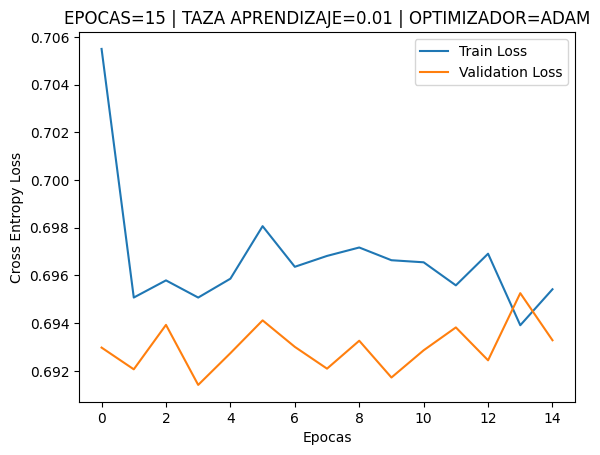

In [24]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.7069
Epoch [1/20]	Validation	Loss: 0.9901	Validation Accuracy: 25.5%
Epoch [2/20]	Training [10%]	Loss: 0.7445
Epoch [2/20]	Validation	Loss: 0.7477	Validation Accuracy: 52.5%
Epoch [3/20]	Training [15%]	Loss: 0.6721
Epoch [3/20]	Validation	Loss: 0.5854	Validation Accuracy: 74.0%
Epoch [4/20]	Training [20%]	Loss: 0.6524
Epoch [4/20]	Validation	Loss: 0.6265	Validation Accuracy: 70.0%
Epoch [5/20]	Training [25%]	Loss: 0.6863
Epoch [5/20]	Validation	Loss: 0.6151	Validation Accuracy: 69.5%
Epoch [6/20]	Training [30%]	Loss: 0.6239
Epoch [6/20]	Validation	Loss: 0.5797	Validation Accuracy: 75.5%
Epoch [7/20]	Training [35%]	Loss: 0.6603
Epoch [7/20]	Validation	Loss: 0.5882	Validation Accuracy: 76.5%
Epoch [8/20]	Training [40%]	Loss: 0.6346
Epoch [8/20]	Validation	Loss: 0.5827	Validation Accuracy: 79.0%
Epoch [9/20]	Training [45%]	Loss: 0.6340
Epoch [9/20]	Validation	Loss: 0.5922	Validation Accuracy: 79.5%
Epoch [10/20]	Training [50%]	Loss: 0.6088
Epoch [10/20]	

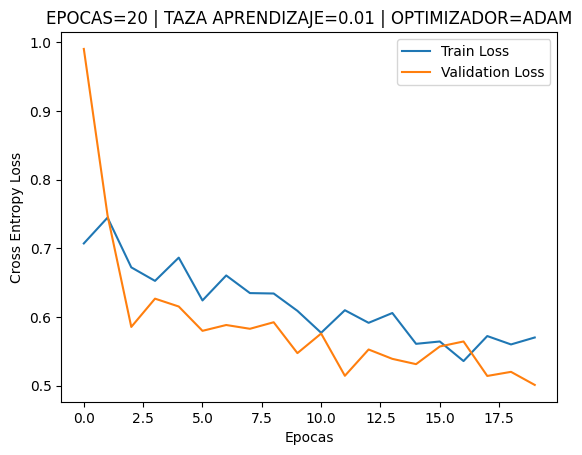

In [25]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6759
Epoch [1/5]	Validation	Loss: 0.6346	Validation Accuracy: 63.0%
Epoch [2/5]	Training [40%]	Loss: 0.6141
Epoch [2/5]	Validation	Loss: 0.5441	Validation Accuracy: 88.5%
Epoch [3/5]	Training [60%]	Loss: 0.5827
Epoch [3/5]	Validation	Loss: 0.5229	Validation Accuracy: 83.5%
Epoch [4/5]	Training [80%]	Loss: 0.5518
Epoch [4/5]	Validation	Loss: 0.4781	Validation Accuracy: 86.5%
Epoch [5/5]	Training [100%]	Loss: 0.5361
Epoch [5/5]	Validation	Loss: 0.4649	Validation Accuracy: 86.0%
Performance on the test data:
	Loss: 0.4649
	Accuracy: 86.0%
	precision: 88.6%
	recall: 86.0%
	f_score: 85.8%
(0.8861003861003861, 0.86, 0.8575933272301902, None)

Confusion Matrix:
[[99  1]
 [27 73]]


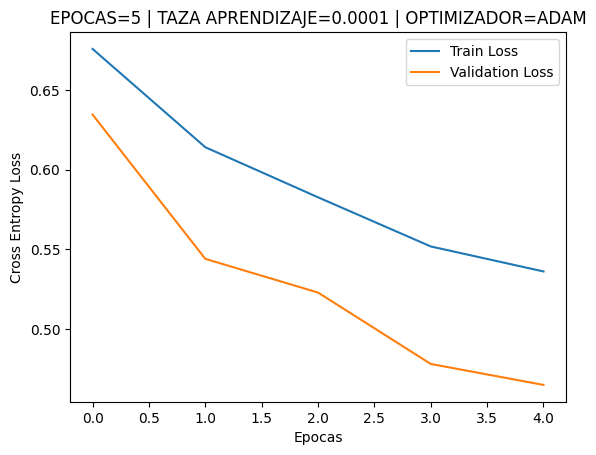

In [26]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6828
Epoch [1/10]	Validation	Loss: 0.6408	Validation Accuracy: 54.5%
Epoch [2/10]	Training [20%]	Loss: 0.6180
Epoch [2/10]	Validation	Loss: 0.5263	Validation Accuracy: 87.0%
Epoch [3/10]	Training [30%]	Loss: 0.5592
Epoch [3/10]	Validation	Loss: 0.4761	Validation Accuracy: 87.0%
Epoch [4/10]	Training [40%]	Loss: 0.5403
Epoch [4/10]	Validation	Loss: 0.4982	Validation Accuracy: 81.0%
Epoch [5/10]	Training [50%]	Loss: 0.5229
Epoch [5/10]	Validation	Loss: 0.4602	Validation Accuracy: 88.0%
Epoch [6/10]	Training [60%]	Loss: 0.5228
Epoch [6/10]	Validation	Loss: 0.4644	Validation Accuracy: 86.0%
Epoch [7/10]	Training [70%]	Loss: 0.5076
Epoch [7/10]	Validation	Loss: 0.4506	Validation Accuracy: 88.5%
Epoch [8/10]	Training [80%]	Loss: 0.5094
Epoch [8/10]	Validation	Loss: 0.4434	Validation Accuracy: 90.5%
Epoch [9/10]	Training [90%]	Loss: 0.4939
Epoch [9/10]	Validation	Loss: 0.4423	Validation Accuracy: 89.5%
Epoch [10/10]	Training [100%]	Loss: 0.4924
Epoch [10/10

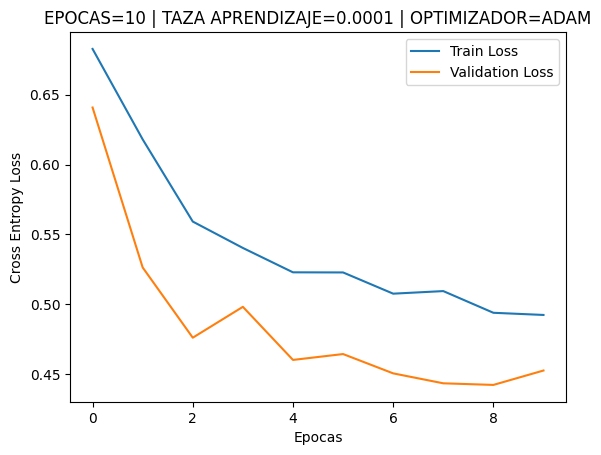

In [27]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6818
Epoch [1/15]	Validation	Loss: 0.6427	Validation Accuracy: 51.0%
Epoch [2/15]	Training [13%]	Loss: 0.6254
Epoch [2/15]	Validation	Loss: 0.5453	Validation Accuracy: 84.5%
Epoch [3/15]	Training [20%]	Loss: 0.5389
Epoch [3/15]	Validation	Loss: 0.4798	Validation Accuracy: 88.5%
Epoch [4/15]	Training [27%]	Loss: 0.5515
Epoch [4/15]	Validation	Loss: 0.4665	Validation Accuracy: 86.0%
Epoch [5/15]	Training [33%]	Loss: 0.5170
Epoch [5/15]	Validation	Loss: 0.4594	Validation Accuracy: 88.0%
Epoch [6/15]	Training [40%]	Loss: 0.5227
Epoch [6/15]	Validation	Loss: 0.4513	Validation Accuracy: 89.5%
Epoch [7/15]	Training [47%]	Loss: 0.4919
Epoch [7/15]	Validation	Loss: 0.4631	Validation Accuracy: 85.0%
Epoch [8/15]	Training [53%]	Loss: 0.4732
Epoch [8/15]	Validation	Loss: 0.4430	Validation Accuracy: 86.0%
Epoch [9/15]	Training [60%]	Loss: 0.4888
Epoch [9/15]	Validation	Loss: 0.4350	Validation Accuracy: 92.0%
Epoch [10/15]	Training [67%]	Loss: 0.4744
Epoch [10/15]	

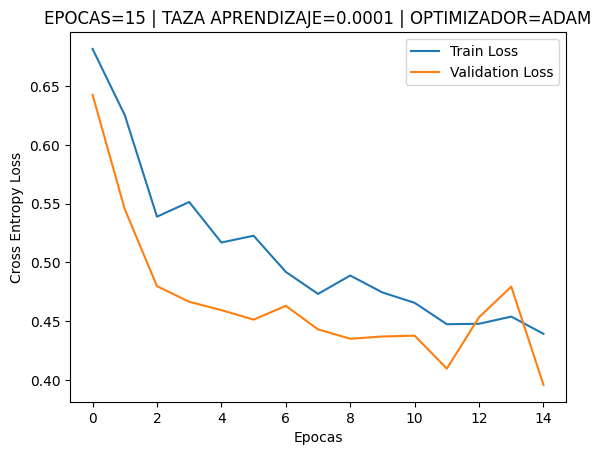

In [28]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = ADAM

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6882
Epoch [1/20]	Validation	Loss: 0.6622	Validation Accuracy: 50.0%
Epoch [2/20]	Training [10%]	Loss: 0.6544
Epoch [2/20]	Validation	Loss: 0.6062	Validation Accuracy: 88.0%
Epoch [3/20]	Training [15%]	Loss: 0.6068
Epoch [3/20]	Validation	Loss: 0.5543	Validation Accuracy: 79.5%
Epoch [4/20]	Training [20%]	Loss: 0.5639
Epoch [4/20]	Validation	Loss: 0.5544	Validation Accuracy: 73.5%
Epoch [5/20]	Training [25%]	Loss: 0.5527
Epoch [5/20]	Validation	Loss: 0.4861	Validation Accuracy: 86.0%
Epoch [6/20]	Training [30%]	Loss: 0.5488
Epoch [6/20]	Validation	Loss: 0.4958	Validation Accuracy: 84.0%
Epoch [7/20]	Training [35%]	Loss: 0.5450
Epoch [7/20]	Validation	Loss: 0.4815	Validation Accuracy: 87.0%
Epoch [8/20]	Training [40%]	Loss: 0.5239
Epoch [8/20]	Validation	Loss: 0.4789	Validation Accuracy: 82.5%
Epoch [9/20]	Training [45%]	Loss: 0.5092
Epoch [9/20]	Validation	Loss: 0.4629	Validation Accuracy: 88.0%
Epoch [10/20]	Training [50%]	Loss: 0.5021
Epoch [10/20]	

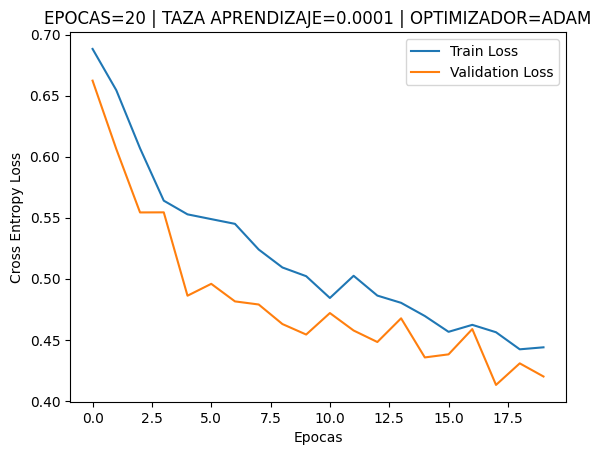

In [29]:
model = Net(num_qubits)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=ADAM')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

--------------------------------------SGD-----------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6910
Epoch [1/5]	Validation	Loss: 0.6867	Validation Accuracy: 61.5%
Epoch [2/5]	Training [40%]	Loss: 0.6863
Epoch [2/5]	Validation	Loss: 0.6832	Validation Accuracy: 60.0%
Epoch [3/5]	Training [60%]	Loss: 0.6845
Epoch [3/5]	Validation	Loss: 0.6796	Validation Accuracy: 52.0%
Epoch [4/5]	Training [80%]	Loss: 0.6849
Epoch [4/5]	Validation	Loss: 0.6750	Validation Accuracy: 51.5%
Epoch [5/5]	Training [100%]	Loss: 0.6775
Epoch [5/5]	Validation	Loss: 0.6681	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 0.6681
	Accuracy: 50.0%
	precision: 25.0%
	recall: 50.0%
	f_score: 33.3%
(0.25, 0.5, 0.3333333333333333, None)

Confusion Matrix:
[[  0 100]
 [  0 100]]


C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


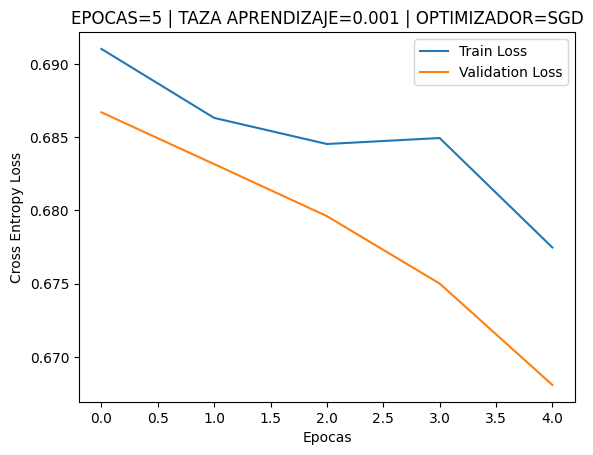

In [30]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6934
Epoch [1/10]	Validation	Loss: 0.6913	Validation Accuracy: 54.0%
Epoch [2/10]	Training [20%]	Loss: 0.6952
Epoch [2/10]	Validation	Loss: 0.6920	Validation Accuracy: 53.0%
Epoch [3/10]	Training [30%]	Loss: 0.6939
Epoch [3/10]	Validation	Loss: 0.6921	Validation Accuracy: 53.0%
Epoch [4/10]	Training [40%]	Loss: 0.6923
Epoch [4/10]	Validation	Loss: 0.6910	Validation Accuracy: 55.0%
Epoch [5/10]	Training [50%]	Loss: 0.6913
Epoch [5/10]	Validation	Loss: 0.6912	Validation Accuracy: 58.0%
Epoch [6/10]	Training [60%]	Loss: 0.6922
Epoch [6/10]	Validation	Loss: 0.6917	Validation Accuracy: 56.5%
Epoch [7/10]	Training [70%]	Loss: 0.6924
Epoch [7/10]	Validation	Loss: 0.6903	Validation Accuracy: 54.5%
Epoch [8/10]	Training [80%]	Loss: 0.6918
Epoch [8/10]	Validation	Loss: 0.6911	Validation Accuracy: 55.5%
Epoch [9/10]	Training [90%]	Loss: 0.6886
Epoch [9/10]	Validation	Loss: 0.6873	Validation Accuracy: 52.5%
Epoch [10/10]	Training [100%]	Loss: 0.6881
Epoch [10/10

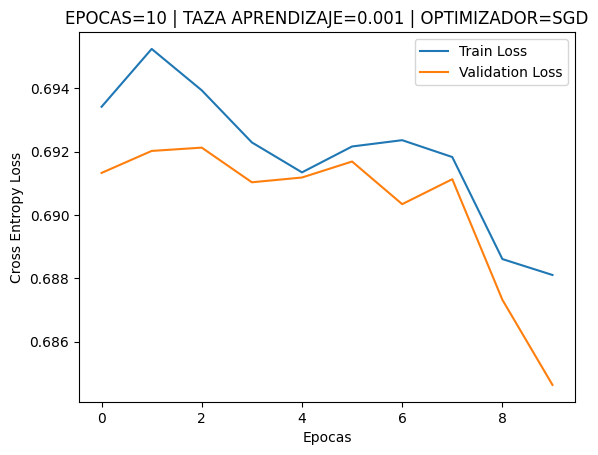

In [31]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6923
Epoch [1/15]	Validation	Loss: 0.6905	Validation Accuracy: 56.5%
Epoch [2/15]	Training [13%]	Loss: 0.6894
Epoch [2/15]	Validation	Loss: 0.6838	Validation Accuracy: 55.0%
Epoch [3/15]	Training [20%]	Loss: 0.6819
Epoch [3/15]	Validation	Loss: 0.6738	Validation Accuracy: 50.5%
Epoch [4/15]	Training [27%]	Loss: 0.6779
Epoch [4/15]	Validation	Loss: 0.6703	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 0.6702
Epoch [5/15]	Validation	Loss: 0.6607	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 0.6700
Epoch [6/15]	Validation	Loss: 0.6545	Validation Accuracy: 56.0%
Epoch [7/15]	Training [47%]	Loss: 0.6647
Epoch [7/15]	Validation	Loss: 0.6470	Validation Accuracy: 61.0%
Epoch [8/15]	Training [53%]	Loss: 0.6587
Epoch [8/15]	Validation	Loss: 0.6399	Validation Accuracy: 65.0%
Epoch [9/15]	Training [60%]	Loss: 0.6473
Epoch [9/15]	Validation	Loss: 0.6413	Validation Accuracy: 79.5%
Epoch [10/15]	Training [67%]	Loss: 0.6459
Epoch [10/15]	

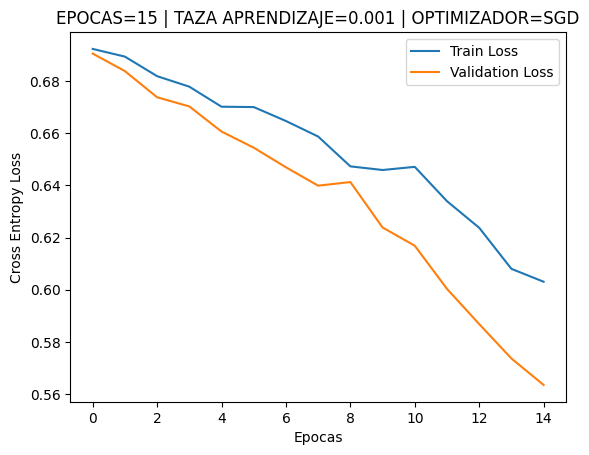

In [32]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6909
Epoch [1/20]	Validation	Loss: 0.6891	Validation Accuracy: 56.0%
Epoch [2/20]	Training [10%]	Loss: 0.6899
Epoch [2/20]	Validation	Loss: 0.6865	Validation Accuracy: 56.0%
Epoch [3/20]	Training [15%]	Loss: 0.6897
Epoch [3/20]	Validation	Loss: 0.6824	Validation Accuracy: 54.0%
Epoch [4/20]	Training [20%]	Loss: 0.6863
Epoch [4/20]	Validation	Loss: 0.6773	Validation Accuracy: 53.0%
Epoch [5/20]	Training [25%]	Loss: 0.6825
Epoch [5/20]	Validation	Loss: 0.6722	Validation Accuracy: 50.0%
Epoch [6/20]	Training [30%]	Loss: 0.6759
Epoch [6/20]	Validation	Loss: 0.6655	Validation Accuracy: 51.5%
Epoch [7/20]	Training [35%]	Loss: 0.6720
Epoch [7/20]	Validation	Loss: 0.6566	Validation Accuracy: 54.0%
Epoch [8/20]	Training [40%]	Loss: 0.6586
Epoch [8/20]	Validation	Loss: 0.6470	Validation Accuracy: 51.5%
Epoch [9/20]	Training [45%]	Loss: 0.6606
Epoch [9/20]	Validation	Loss: 0.6411	Validation Accuracy: 59.0%
Epoch [10/20]	Training [50%]	Loss: 0.6468
Epoch [10/20]	

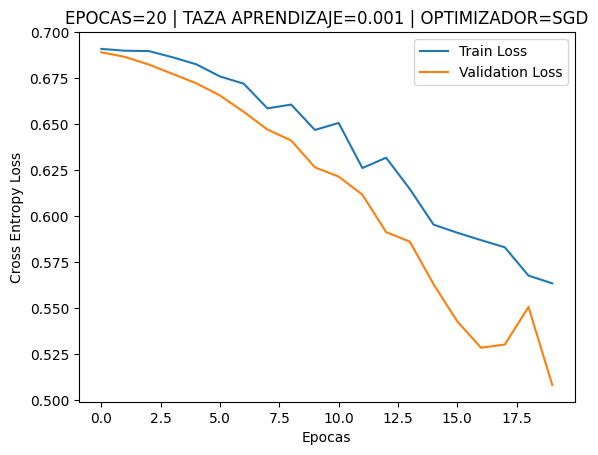

In [33]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6891
Epoch [1/5]	Validation	Loss: 0.6543	Validation Accuracy: 81.5%
Epoch [2/5]	Training [40%]	Loss: 0.6573
Epoch [2/5]	Validation	Loss: 0.6019	Validation Accuracy: 79.0%
Epoch [3/5]	Training [60%]	Loss: 0.6255
Epoch [3/5]	Validation	Loss: 0.6976	Validation Accuracy: 51.0%
Epoch [4/5]	Training [80%]	Loss: 0.5915
Epoch [4/5]	Validation	Loss: 0.6774	Validation Accuracy: 55.5%
Epoch [5/5]	Training [100%]	Loss: 0.5910
Epoch [5/5]	Validation	Loss: 0.5201	Validation Accuracy: 84.5%
Performance on the test data:
	Loss: 0.5201
	Accuracy: 84.5%
	precision: 87.7%
	recall: 84.5%
	f_score: 84.2%
(0.8766786767114314, 0.845, 0.8416711356265482, None)

Confusion Matrix:
[[99  1]
 [30 70]]


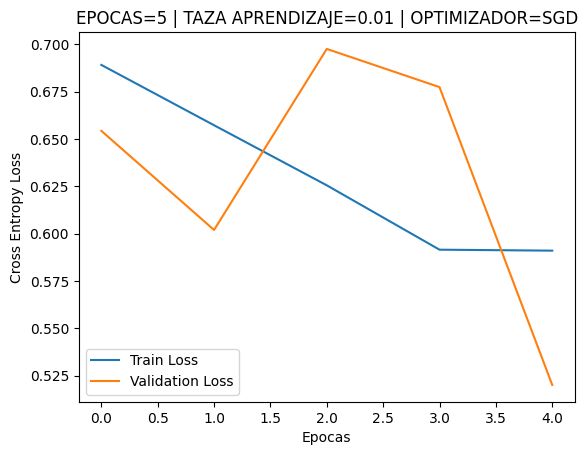

In [34]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6887
Epoch [1/10]	Validation	Loss: 0.6591	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 0.6755
Epoch [2/10]	Validation	Loss: 0.6312	Validation Accuracy: 50.5%
Epoch [3/10]	Training [30%]	Loss: 0.6454
Epoch [3/10]	Validation	Loss: 0.5503	Validation Accuracy: 83.5%
Epoch [4/10]	Training [40%]	Loss: 0.6193
Epoch [4/10]	Validation	Loss: 0.5574	Validation Accuracy: 76.0%
Epoch [5/10]	Training [50%]	Loss: 0.6057
Epoch [5/10]	Validation	Loss: 0.5327	Validation Accuracy: 80.0%
Epoch [6/10]	Training [60%]	Loss: 0.5763
Epoch [6/10]	Validation	Loss: 0.5508	Validation Accuracy: 75.0%
Epoch [7/10]	Training [70%]	Loss: 0.5559
Epoch [7/10]	Validation	Loss: 0.5056	Validation Accuracy: 92.0%
Epoch [8/10]	Training [80%]	Loss: 0.5551
Epoch [8/10]	Validation	Loss: 0.5698	Validation Accuracy: 72.0%
Epoch [9/10]	Training [90%]	Loss: 0.5353
Epoch [9/10]	Validation	Loss: 0.6371	Validation Accuracy: 65.0%
Epoch [10/10]	Training [100%]	Loss: 0.5490
Epoch [10/10

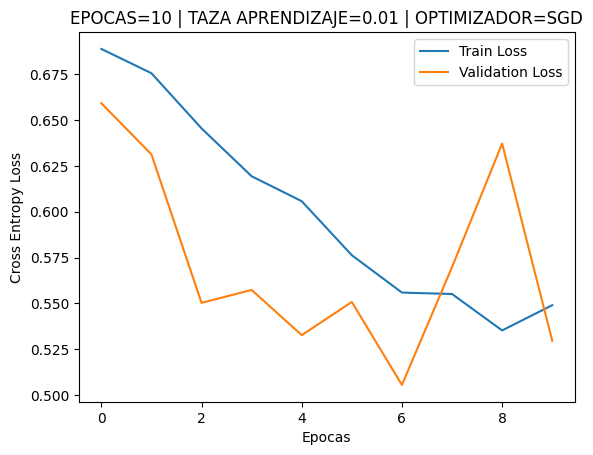

In [35]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6932
Epoch [1/15]	Validation	Loss: 0.6516	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 0.6529
Epoch [2/15]	Validation	Loss: 0.6266	Validation Accuracy: 73.5%
Epoch [3/15]	Training [20%]	Loss: 0.6226
Epoch [3/15]	Validation	Loss: 0.5525	Validation Accuracy: 79.0%
Epoch [4/15]	Training [27%]	Loss: 0.6180
Epoch [4/15]	Validation	Loss: 0.5332	Validation Accuracy: 84.0%
Epoch [5/15]	Training [33%]	Loss: 0.6580
Epoch [5/15]	Validation	Loss: 0.6022	Validation Accuracy: 69.0%
Epoch [6/15]	Training [40%]	Loss: 0.5875
Epoch [6/15]	Validation	Loss: 0.5237	Validation Accuracy: 84.5%
Epoch [7/15]	Training [47%]	Loss: 0.6234
Epoch [7/15]	Validation	Loss: 0.8338	Validation Accuracy: 39.0%
Epoch [8/15]	Training [53%]	Loss: 0.6995
Epoch [8/15]	Validation	Loss: 0.6738	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 0.6503
Epoch [9/15]	Validation	Loss: 0.6313	Validation Accuracy: 60.5%
Epoch [10/15]	Training [67%]	Loss: 0.5990
Epoch [10/15]	

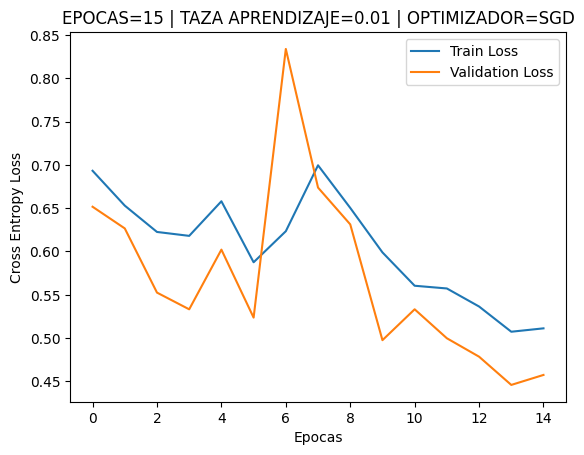

In [36]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6878
Epoch [1/20]	Validation	Loss: 0.6666	Validation Accuracy: 67.5%
Epoch [2/20]	Training [10%]	Loss: 0.6412
Epoch [2/20]	Validation	Loss: 0.6163	Validation Accuracy: 72.5%
Epoch [3/20]	Training [15%]	Loss: 0.6533
Epoch [3/20]	Validation	Loss: 0.7221	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 0.7060
Epoch [4/20]	Validation	Loss: 0.6932	Validation Accuracy: 50.0%
Epoch [5/20]	Training [25%]	Loss: 0.6957
Epoch [5/20]	Validation	Loss: 0.6901	Validation Accuracy: 56.0%
Epoch [6/20]	Training [30%]	Loss: 0.6944
Epoch [6/20]	Validation	Loss: 0.6731	Validation Accuracy: 65.5%
Epoch [7/20]	Training [35%]	Loss: 0.6320
Epoch [7/20]	Validation	Loss: 0.5933	Validation Accuracy: 75.0%
Epoch [8/20]	Training [40%]	Loss: 0.5954
Epoch [8/20]	Validation	Loss: 0.5755	Validation Accuracy: 80.5%
Epoch [9/20]	Training [45%]	Loss: 0.5752
Epoch [9/20]	Validation	Loss: 0.5535	Validation Accuracy: 77.0%
Epoch [10/20]	Training [50%]	Loss: 0.5508
Epoch [10/20]	

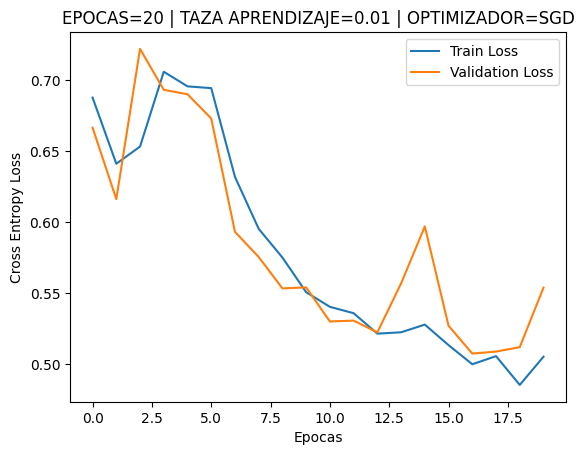

In [38]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6936
Epoch [1/5]	Validation	Loss: 0.6913	Validation Accuracy: 52.0%
Epoch [2/5]	Training [40%]	Loss: 0.6925
Epoch [2/5]	Validation	Loss: 0.6916	Validation Accuracy: 56.0%
Epoch [3/5]	Training [60%]	Loss: 0.6918
Epoch [3/5]	Validation	Loss: 0.6938	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 0.6932
Epoch [4/5]	Validation	Loss: 0.6912	Validation Accuracy: 57.5%
Epoch [5/5]	Training [100%]	Loss: 0.6942
Epoch [5/5]	Validation	Loss: 0.6920	Validation Accuracy: 50.5%
Performance on the test data:
	Loss: 0.6920
	Accuracy: 50.5%
	precision: 50.7%
	recall: 50.5%
	f_score: 46.8%
(0.5069531358642747, 0.505, 0.4676131322094055, None)

Confusion Matrix:
[[77 23]
 [76 24]]


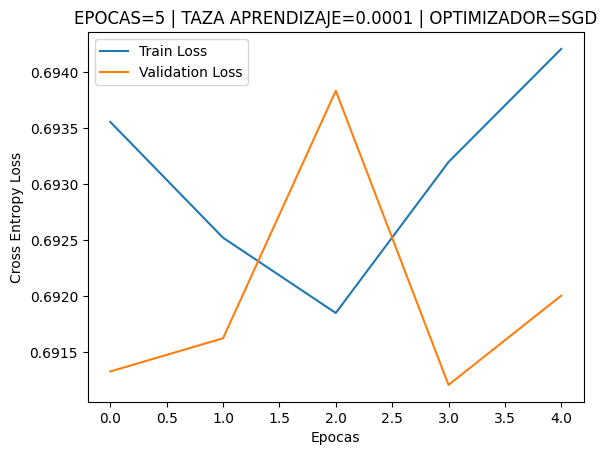

In [39]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6899
Epoch [1/10]	Validation	Loss: 0.6924	Validation Accuracy: 51.5%
Epoch [2/10]	Training [20%]	Loss: 0.6919
Epoch [2/10]	Validation	Loss: 0.6919	Validation Accuracy: 55.0%
Epoch [3/10]	Training [30%]	Loss: 0.6897
Epoch [3/10]	Validation	Loss: 0.6900	Validation Accuracy: 58.5%
Epoch [4/10]	Training [40%]	Loss: 0.6920
Epoch [4/10]	Validation	Loss: 0.6894	Validation Accuracy: 54.5%
Epoch [5/10]	Training [50%]	Loss: 0.6898
Epoch [5/10]	Validation	Loss: 0.6914	Validation Accuracy: 57.0%
Epoch [6/10]	Training [60%]	Loss: 0.6896
Epoch [6/10]	Validation	Loss: 0.6891	Validation Accuracy: 57.5%
Epoch [7/10]	Training [70%]	Loss: 0.6905
Epoch [7/10]	Validation	Loss: 0.6896	Validation Accuracy: 58.0%
Epoch [8/10]	Training [80%]	Loss: 0.6897
Epoch [8/10]	Validation	Loss: 0.6881	Validation Accuracy: 59.0%
Epoch [9/10]	Training [90%]	Loss: 0.6883
Epoch [9/10]	Validation	Loss: 0.6892	Validation Accuracy: 55.5%
Epoch [10/10]	Training [100%]	Loss: 0.6926
Epoch [10/10

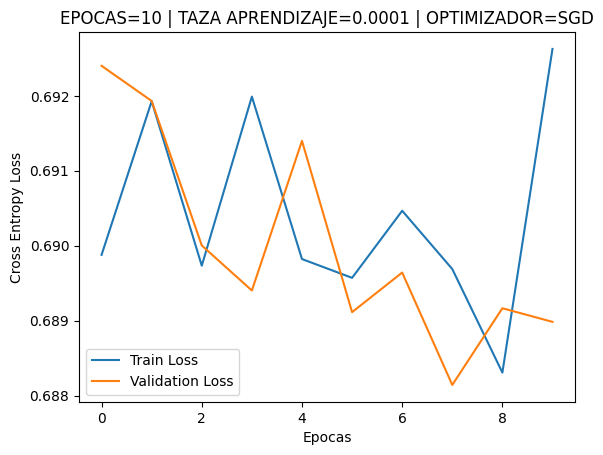

In [41]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6960
Epoch [1/15]	Validation	Loss: 0.6962	Validation Accuracy: 49.5%
Epoch [2/15]	Training [13%]	Loss: 0.6959
Epoch [2/15]	Validation	Loss: 0.6949	Validation Accuracy: 48.5%
Epoch [3/15]	Training [20%]	Loss: 0.6963
Epoch [3/15]	Validation	Loss: 0.6930	Validation Accuracy: 49.5%
Epoch [4/15]	Training [27%]	Loss: 0.6925
Epoch [4/15]	Validation	Loss: 0.6936	Validation Accuracy: 49.0%
Epoch [5/15]	Training [33%]	Loss: 0.6948
Epoch [5/15]	Validation	Loss: 0.6917	Validation Accuracy: 53.0%
Epoch [6/15]	Training [40%]	Loss: 0.6944
Epoch [6/15]	Validation	Loss: 0.6945	Validation Accuracy: 48.0%
Epoch [7/15]	Training [47%]	Loss: 0.6931
Epoch [7/15]	Validation	Loss: 0.6917	Validation Accuracy: 51.5%
Epoch [8/15]	Training [53%]	Loss: 0.6927
Epoch [8/15]	Validation	Loss: 0.6904	Validation Accuracy: 55.0%
Epoch [9/15]	Training [60%]	Loss: 0.6956
Epoch [9/15]	Validation	Loss: 0.6924	Validation Accuracy: 55.5%
Epoch [10/15]	Training [67%]	Loss: 0.6916
Epoch [10/15]	

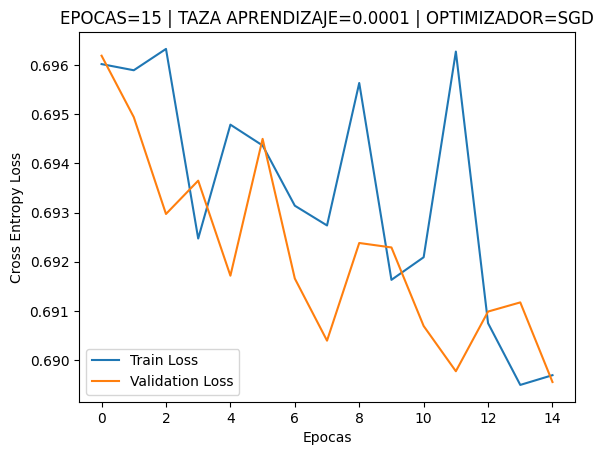

In [42]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = SGD

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6957
Epoch [1/20]	Validation	Loss: 0.6938	Validation Accuracy: 51.5%
Epoch [2/20]	Training [10%]	Loss: 0.6928
Epoch [2/20]	Validation	Loss: 0.6936	Validation Accuracy: 49.5%
Epoch [3/20]	Training [15%]	Loss: 0.6943
Epoch [3/20]	Validation	Loss: 0.6946	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 0.6928
Epoch [4/20]	Validation	Loss: 0.6924	Validation Accuracy: 52.0%
Epoch [5/20]	Training [25%]	Loss: 0.6918
Epoch [5/20]	Validation	Loss: 0.6942	Validation Accuracy: 48.5%
Epoch [6/20]	Training [30%]	Loss: 0.6914
Epoch [6/20]	Validation	Loss: 0.6919	Validation Accuracy: 52.0%
Epoch [7/20]	Training [35%]	Loss: 0.6951
Epoch [7/20]	Validation	Loss: 0.6928	Validation Accuracy: 51.5%
Epoch [8/20]	Training [40%]	Loss: 0.6936
Epoch [8/20]	Validation	Loss: 0.6918	Validation Accuracy: 56.5%
Epoch [9/20]	Training [45%]	Loss: 0.6930
Epoch [9/20]	Validation	Loss: 0.6924	Validation Accuracy: 51.0%
Epoch [10/20]	Training [50%]	Loss: 0.6917
Epoch [10/20]	

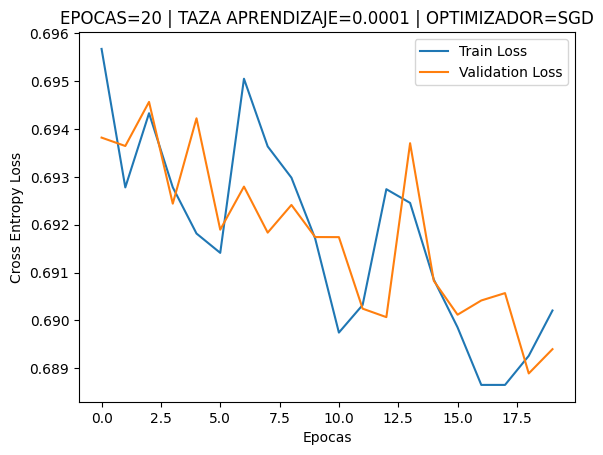

In [43]:
model = Net(num_qubits)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=SGD')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------Adadelta--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6930
Epoch [1/5]	Validation	Loss: 0.6926	Validation Accuracy: 53.0%
Epoch [2/5]	Training [40%]	Loss: 0.6936
Epoch [2/5]	Validation	Loss: 0.6924	Validation Accuracy: 51.5%
Epoch [3/5]	Training [60%]	Loss: 0.6927
Epoch [3/5]	Validation	Loss: 0.6927	Validation Accuracy: 53.0%
Epoch [4/5]	Training [80%]	Loss: 0.6920
Epoch [4/5]	Validation	Loss: 0.6940	Validation Accuracy: 48.0%
Epoch [5/5]	Training [100%]	Loss: 0.6914
Epoch [5/5]	Validation	Loss: 0.6936	Validation Accuracy: 52.5%
Performance on the test data:
	Loss: 0.6936
	Accuracy: 52.5%
	precision: 52.9%
	recall: 52.5%
	f_score: 50.6%
(0.5294846090340842, 0.525, 0.5062241742249018, None)

Confusion Matrix:
[[72 28]
 [67 33]]


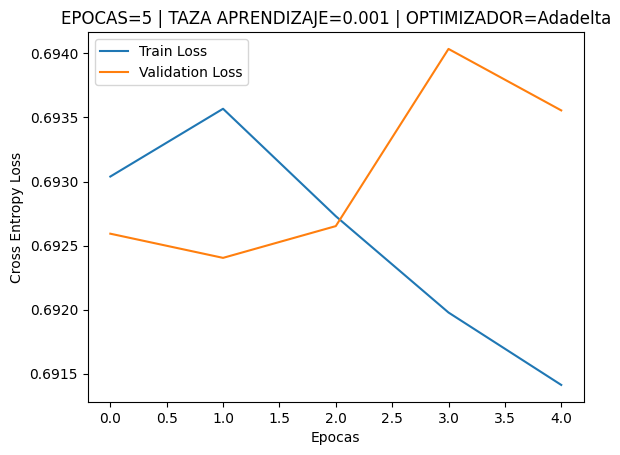

In [44]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6932
Epoch [1/10]	Validation	Loss: 0.6954	Validation Accuracy: 50.0%
Epoch [2/10]	Training [20%]	Loss: 0.6948
Epoch [2/10]	Validation	Loss: 0.6954	Validation Accuracy: 51.0%
Epoch [3/10]	Training [30%]	Loss: 0.6923
Epoch [3/10]	Validation	Loss: 0.6937	Validation Accuracy: 51.5%
Epoch [4/10]	Training [40%]	Loss: 0.6942
Epoch [4/10]	Validation	Loss: 0.6948	Validation Accuracy: 51.0%
Epoch [5/10]	Training [50%]	Loss: 0.6931
Epoch [5/10]	Validation	Loss: 0.6918	Validation Accuracy: 53.5%
Epoch [6/10]	Training [60%]	Loss: 0.6933
Epoch [6/10]	Validation	Loss: 0.6927	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 0.6937
Epoch [7/10]	Validation	Loss: 0.6927	Validation Accuracy: 51.0%
Epoch [8/10]	Training [80%]	Loss: 0.6923
Epoch [8/10]	Validation	Loss: 0.6935	Validation Accuracy: 50.5%
Epoch [9/10]	Training [90%]	Loss: 0.6928
Epoch [9/10]	Validation	Loss: 0.6915	Validation Accuracy: 53.5%
Epoch [10/10]	Training [100%]	Loss: 0.6917
Epoch [10/10

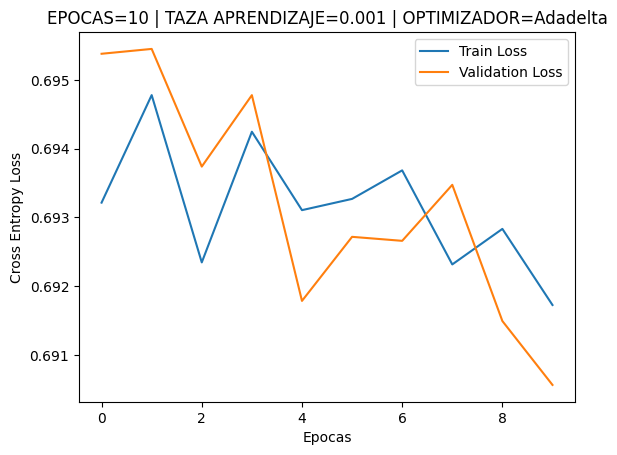

In [45]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6909
Epoch [1/15]	Validation	Loss: 0.6908	Validation Accuracy: 53.5%
Epoch [2/15]	Training [13%]	Loss: 0.6930
Epoch [2/15]	Validation	Loss: 0.6930	Validation Accuracy: 52.5%
Epoch [3/15]	Training [20%]	Loss: 0.6891
Epoch [3/15]	Validation	Loss: 0.6905	Validation Accuracy: 59.0%
Epoch [4/15]	Training [27%]	Loss: 0.6897
Epoch [4/15]	Validation	Loss: 0.6896	Validation Accuracy: 59.0%
Epoch [5/15]	Training [33%]	Loss: 0.6875
Epoch [5/15]	Validation	Loss: 0.6876	Validation Accuracy: 55.5%
Epoch [6/15]	Training [40%]	Loss: 0.6866
Epoch [6/15]	Validation	Loss: 0.6882	Validation Accuracy: 58.5%
Epoch [7/15]	Training [47%]	Loss: 0.6885
Epoch [7/15]	Validation	Loss: 0.6828	Validation Accuracy: 66.0%
Epoch [8/15]	Training [53%]	Loss: 0.6886
Epoch [8/15]	Validation	Loss: 0.6881	Validation Accuracy: 57.0%
Epoch [9/15]	Training [60%]	Loss: 0.6837
Epoch [9/15]	Validation	Loss: 0.6862	Validation Accuracy: 59.0%
Epoch [10/15]	Training [67%]	Loss: 0.6857
Epoch [10/15]	

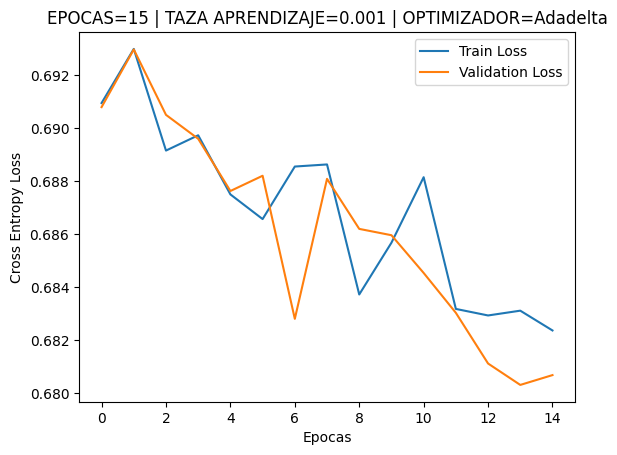

In [46]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6938
Epoch [1/20]	Validation	Loss: 0.6937	Validation Accuracy: 46.5%
Epoch [2/20]	Training [10%]	Loss: 0.6942
Epoch [2/20]	Validation	Loss: 0.6925	Validation Accuracy: 49.5%
Epoch [3/20]	Training [15%]	Loss: 0.6946
Epoch [3/20]	Validation	Loss: 0.6928	Validation Accuracy: 50.0%
Epoch [4/20]	Training [20%]	Loss: 0.6914
Epoch [4/20]	Validation	Loss: 0.6932	Validation Accuracy: 52.5%
Epoch [5/20]	Training [25%]	Loss: 0.6954
Epoch [5/20]	Validation	Loss: 0.6918	Validation Accuracy: 54.0%
Epoch [6/20]	Training [30%]	Loss: 0.6920
Epoch [6/20]	Validation	Loss: 0.6956	Validation Accuracy: 45.0%
Epoch [7/20]	Training [35%]	Loss: 0.6936
Epoch [7/20]	Validation	Loss: 0.6917	Validation Accuracy: 51.5%
Epoch [8/20]	Training [40%]	Loss: 0.6925
Epoch [8/20]	Validation	Loss: 0.6910	Validation Accuracy: 54.0%
Epoch [9/20]	Training [45%]	Loss: 0.6928
Epoch [9/20]	Validation	Loss: 0.6911	Validation Accuracy: 54.0%
Epoch [10/20]	Training [50%]	Loss: 0.6910
Epoch [10/20]	

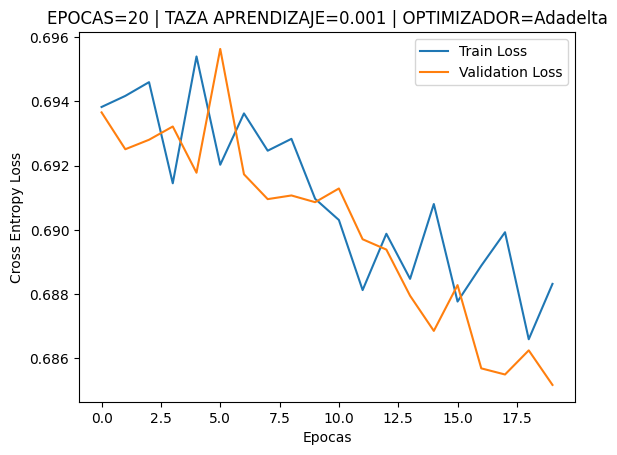

In [47]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ********************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6957
Epoch [1/5]	Validation	Loss: 0.6918	Validation Accuracy: 52.0%
Epoch [2/5]	Training [40%]	Loss: 0.6906
Epoch [2/5]	Validation	Loss: 0.6877	Validation Accuracy: 56.5%
Epoch [3/5]	Training [60%]	Loss: 0.6870
Epoch [3/5]	Validation	Loss: 0.6809	Validation Accuracy: 53.5%
Epoch [4/5]	Training [80%]	Loss: 0.6859
Epoch [4/5]	Validation	Loss: 0.6771	Validation Accuracy: 52.0%
Epoch [5/5]	Training [100%]	Loss: 0.6804
Epoch [5/5]	Validation	Loss: 0.6735	Validation Accuracy: 51.5%
Performance on the test data:
	Loss: 0.6735
	Accuracy: 51.5%
	precision: 75.4%
	recall: 51.5%
	f_score: 36.6%
(0.7538071065989848, 0.515, 0.36582655029256966, None)

Confusion Matrix:
[[  3  97]
 [  0 100]]


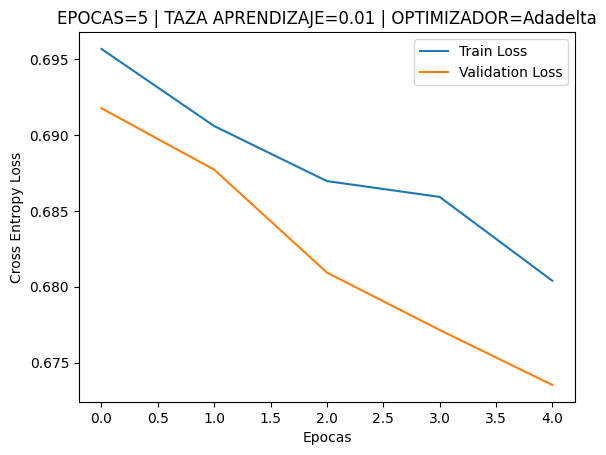

In [48]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6940
Epoch [1/10]	Validation	Loss: 0.6921	Validation Accuracy: 51.0%
Epoch [2/10]	Training [20%]	Loss: 0.6889
Epoch [2/10]	Validation	Loss: 0.6867	Validation Accuracy: 52.5%
Epoch [3/10]	Training [30%]	Loss: 0.6839
Epoch [3/10]	Validation	Loss: 0.6807	Validation Accuracy: 52.0%
Epoch [4/10]	Training [40%]	Loss: 0.6827
Epoch [4/10]	Validation	Loss: 0.6765	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 0.6745
Epoch [5/10]	Validation	Loss: 0.6685	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 0.6778
Epoch [6/10]	Validation	Loss: 0.6630	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 0.6724
Epoch [7/10]	Validation	Loss: 0.6589	Validation Accuracy: 51.0%
Epoch [8/10]	Training [80%]	Loss: 0.6604
Epoch [8/10]	Validation	Loss: 0.6509	Validation Accuracy: 51.0%
Epoch [9/10]	Training [90%]	Loss: 0.6611
Epoch [9/10]	Validation	Loss: 0.6459	Validation Accuracy: 53.0%
Epoch [10/10]	Training [100%]	Loss: 0.6613
Epoch [10/10

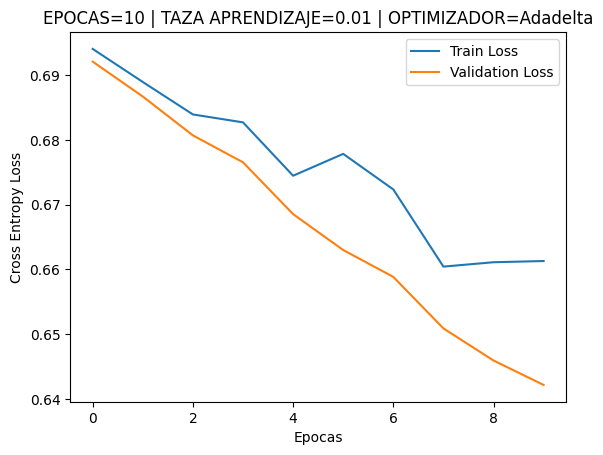

In [49]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6910
Epoch [1/15]	Validation	Loss: 0.6897	Validation Accuracy: 58.0%
Epoch [2/15]	Training [13%]	Loss: 0.6910
Epoch [2/15]	Validation	Loss: 0.6873	Validation Accuracy: 56.0%
Epoch [3/15]	Training [20%]	Loss: 0.6863
Epoch [3/15]	Validation	Loss: 0.6821	Validation Accuracy: 54.0%
Epoch [4/15]	Training [27%]	Loss: 0.6811
Epoch [4/15]	Validation	Loss: 0.6748	Validation Accuracy: 57.5%
Epoch [5/15]	Training [33%]	Loss: 0.6749
Epoch [5/15]	Validation	Loss: 0.6679	Validation Accuracy: 52.5%
Epoch [6/15]	Training [40%]	Loss: 0.6737
Epoch [6/15]	Validation	Loss: 0.6640	Validation Accuracy: 53.5%
Epoch [7/15]	Training [47%]	Loss: 0.6742
Epoch [7/15]	Validation	Loss: 0.6605	Validation Accuracy: 64.0%
Epoch [8/15]	Training [53%]	Loss: 0.6647
Epoch [8/15]	Validation	Loss: 0.6500	Validation Accuracy: 64.0%
Epoch [9/15]	Training [60%]	Loss: 0.6595
Epoch [9/15]	Validation	Loss: 0.6415	Validation Accuracy: 67.0%
Epoch [10/15]	Training [67%]	Loss: 0.6521
Epoch [10/15]	

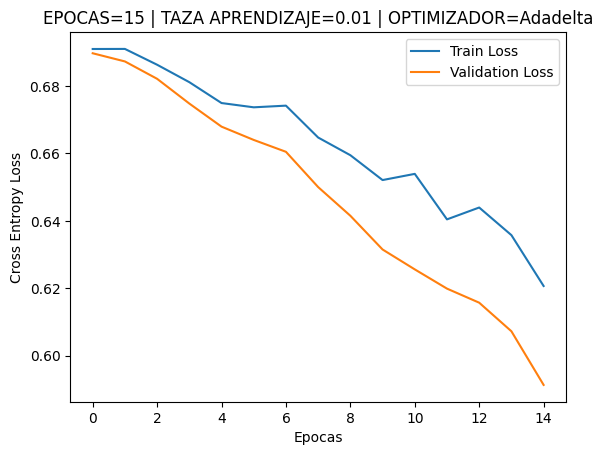

In [50]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6902
Epoch [1/20]	Validation	Loss: 0.6871	Validation Accuracy: 63.5%
Epoch [2/20]	Training [10%]	Loss: 0.6876
Epoch [2/20]	Validation	Loss: 0.6800	Validation Accuracy: 61.0%
Epoch [3/20]	Training [15%]	Loss: 0.6799
Epoch [3/20]	Validation	Loss: 0.6712	Validation Accuracy: 57.0%
Epoch [4/20]	Training [20%]	Loss: 0.6705
Epoch [4/20]	Validation	Loss: 0.6605	Validation Accuracy: 53.5%
Epoch [5/20]	Training [25%]	Loss: 0.6643
Epoch [5/20]	Validation	Loss: 0.6523	Validation Accuracy: 52.0%
Epoch [6/20]	Training [30%]	Loss: 0.6675
Epoch [6/20]	Validation	Loss: 0.6420	Validation Accuracy: 55.5%
Epoch [7/20]	Training [35%]	Loss: 0.6517
Epoch [7/20]	Validation	Loss: 0.6361	Validation Accuracy: 57.0%
Epoch [8/20]	Training [40%]	Loss: 0.6558
Epoch [8/20]	Validation	Loss: 0.6279	Validation Accuracy: 64.5%
Epoch [9/20]	Training [45%]	Loss: 0.6440
Epoch [9/20]	Validation	Loss: 0.6203	Validation Accuracy: 70.5%
Epoch [10/20]	Training [50%]	Loss: 0.6319
Epoch [10/20]	

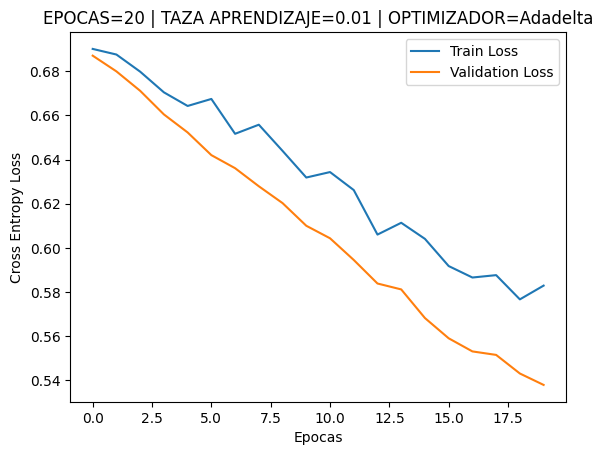

In [51]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6919
Epoch [1/5]	Validation	Loss: 0.6924	Validation Accuracy: 53.0%
Epoch [2/5]	Training [40%]	Loss: 0.6924
Epoch [2/5]	Validation	Loss: 0.6934	Validation Accuracy: 49.0%
Epoch [3/5]	Training [60%]	Loss: 0.6925
Epoch [3/5]	Validation	Loss: 0.6924	Validation Accuracy: 50.0%
Epoch [4/5]	Training [80%]	Loss: 0.6957
Epoch [4/5]	Validation	Loss: 0.6923	Validation Accuracy: 49.0%
Epoch [5/5]	Training [100%]	Loss: 0.6937
Epoch [5/5]	Validation	Loss: 0.6935	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 0.6935
	Accuracy: 50.0%
	precision: 50.0%
	recall: 50.0%
	f_score: 39.3%
(0.5, 0.5, 0.39290917921321034, None)

Confusion Matrix:
[[ 8 92]
 [ 8 92]]


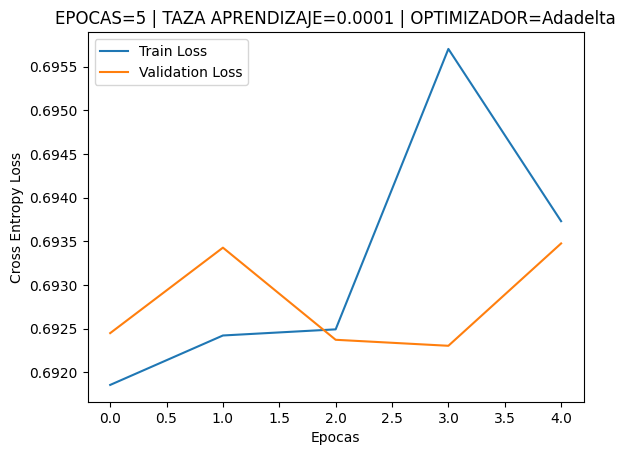

In [52]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6917
Epoch [1/10]	Validation	Loss: 0.6942	Validation Accuracy: 47.5%
Epoch [2/10]	Training [20%]	Loss: 0.6932
Epoch [2/10]	Validation	Loss: 0.6936	Validation Accuracy: 44.5%
Epoch [3/10]	Training [30%]	Loss: 0.6936
Epoch [3/10]	Validation	Loss: 0.6921	Validation Accuracy: 53.0%
Epoch [4/10]	Training [40%]	Loss: 0.6916
Epoch [4/10]	Validation	Loss: 0.6923	Validation Accuracy: 51.5%
Epoch [5/10]	Training [50%]	Loss: 0.6940
Epoch [5/10]	Validation	Loss: 0.6939	Validation Accuracy: 52.0%
Epoch [6/10]	Training [60%]	Loss: 0.6939
Epoch [6/10]	Validation	Loss: 0.6925	Validation Accuracy: 54.0%
Epoch [7/10]	Training [70%]	Loss: 0.6934
Epoch [7/10]	Validation	Loss: 0.6928	Validation Accuracy: 47.5%
Epoch [8/10]	Training [80%]	Loss: 0.6958
Epoch [8/10]	Validation	Loss: 0.6939	Validation Accuracy: 47.5%
Epoch [9/10]	Training [90%]	Loss: 0.6919
Epoch [9/10]	Validation	Loss: 0.6913	Validation Accuracy: 53.5%
Epoch [10/10]	Training [100%]	Loss: 0.6934
Epoch [10/10

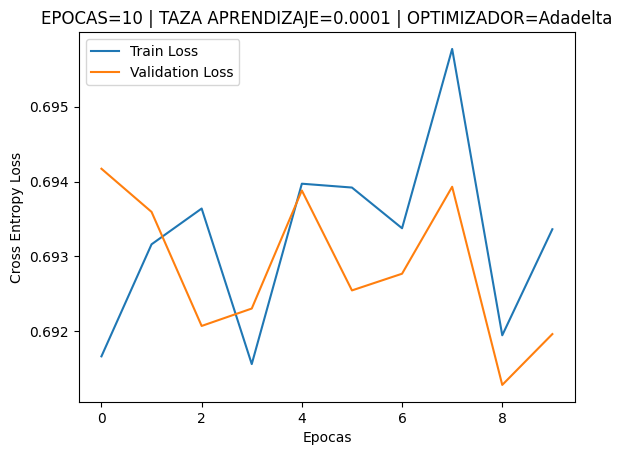

In [53]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6962
Epoch [1/15]	Validation	Loss: 0.6940	Validation Accuracy: 49.0%
Epoch [2/15]	Training [13%]	Loss: 0.6936
Epoch [2/15]	Validation	Loss: 0.6954	Validation Accuracy: 47.5%
Epoch [3/15]	Training [20%]	Loss: 0.6925
Epoch [3/15]	Validation	Loss: 0.6946	Validation Accuracy: 49.0%
Epoch [4/15]	Training [27%]	Loss: 0.6939
Epoch [4/15]	Validation	Loss: 0.6928	Validation Accuracy: 52.0%
Epoch [5/15]	Training [33%]	Loss: 0.6939
Epoch [5/15]	Validation	Loss: 0.6950	Validation Accuracy: 48.0%
Epoch [6/15]	Training [40%]	Loss: 0.6943
Epoch [6/15]	Validation	Loss: 0.6919	Validation Accuracy: 58.0%
Epoch [7/15]	Training [47%]	Loss: 0.6914
Epoch [7/15]	Validation	Loss: 0.6944	Validation Accuracy: 48.5%
Epoch [8/15]	Training [53%]	Loss: 0.6924
Epoch [8/15]	Validation	Loss: 0.6944	Validation Accuracy: 46.0%
Epoch [9/15]	Training [60%]	Loss: 0.6918
Epoch [9/15]	Validation	Loss: 0.6944	Validation Accuracy: 45.0%
Epoch [10/15]	Training [67%]	Loss: 0.6918
Epoch [10/15]	

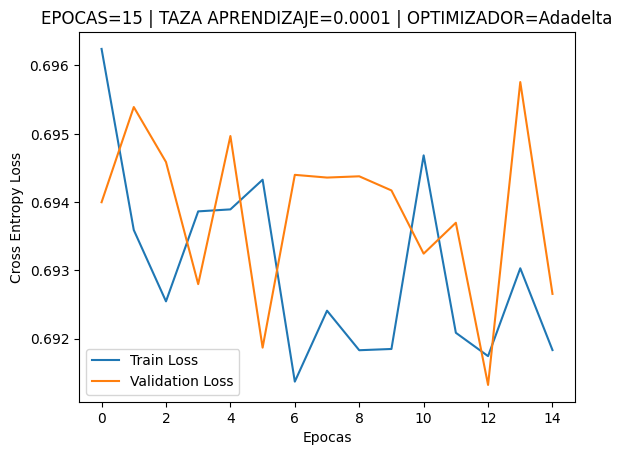

In [54]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = Adadelta

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6910
Epoch [1/20]	Validation	Loss: 0.6929	Validation Accuracy: 49.5%
Epoch [2/20]	Training [10%]	Loss: 0.6917
Epoch [2/20]	Validation	Loss: 0.6926	Validation Accuracy: 50.5%
Epoch [3/20]	Training [15%]	Loss: 0.6895
Epoch [3/20]	Validation	Loss: 0.6918	Validation Accuracy: 54.5%
Epoch [4/20]	Training [20%]	Loss: 0.6910
Epoch [4/20]	Validation	Loss: 0.6928	Validation Accuracy: 52.5%
Epoch [5/20]	Training [25%]	Loss: 0.6914
Epoch [5/20]	Validation	Loss: 0.6922	Validation Accuracy: 52.0%
Epoch [6/20]	Training [30%]	Loss: 0.6911
Epoch [6/20]	Validation	Loss: 0.6915	Validation Accuracy: 52.0%
Epoch [7/20]	Training [35%]	Loss: 0.6923
Epoch [7/20]	Validation	Loss: 0.6912	Validation Accuracy: 55.0%
Epoch [8/20]	Training [40%]	Loss: 0.6921
Epoch [8/20]	Validation	Loss: 0.6911	Validation Accuracy: 55.0%
Epoch [9/20]	Training [45%]	Loss: 0.6914
Epoch [9/20]	Validation	Loss: 0.6932	Validation Accuracy: 50.5%
Epoch [10/20]	Training [50%]	Loss: 0.6889
Epoch [10/20]	

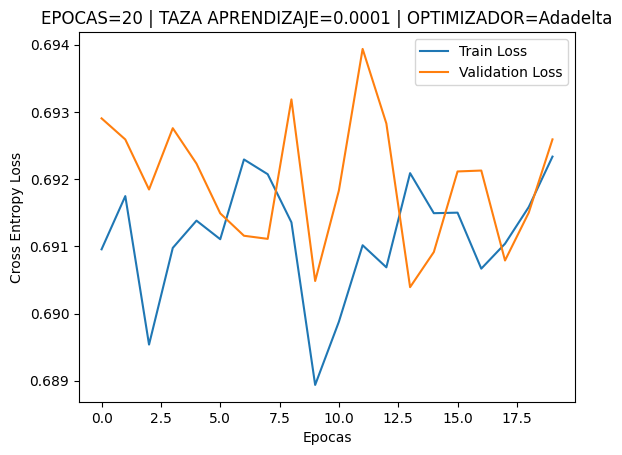

In [55]:
model = Net(num_qubits)
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adadelta')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------Adagrad--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6857
Epoch [1/5]	Validation	Loss: 0.6506	Validation Accuracy: 50.0%
Epoch [2/5]	Training [40%]	Loss: 0.6518
Epoch [2/5]	Validation	Loss: 0.6139	Validation Accuracy: 75.0%
Epoch [3/5]	Training [60%]	Loss: 0.6296
Epoch [3/5]	Validation	Loss: 0.5851	Validation Accuracy: 86.0%
Epoch [4/5]	Training [80%]	Loss: 0.5990
Epoch [4/5]	Validation	Loss: 0.5557	Validation Accuracy: 84.5%
Epoch [5/5]	Training [100%]	Loss: 0.5908
Epoch [5/5]	Validation	Loss: 0.5310	Validation Accuracy: 86.0%
Performance on the test data:
	Loss: 0.5310
	Accuracy: 86.0%
	precision: 87.8%
	recall: 86.0%
	f_score: 85.8%
(0.8783102143757882, 0.86, 0.8582852515436785, None)

Confusion Matrix:
[[97  3]
 [25 75]]


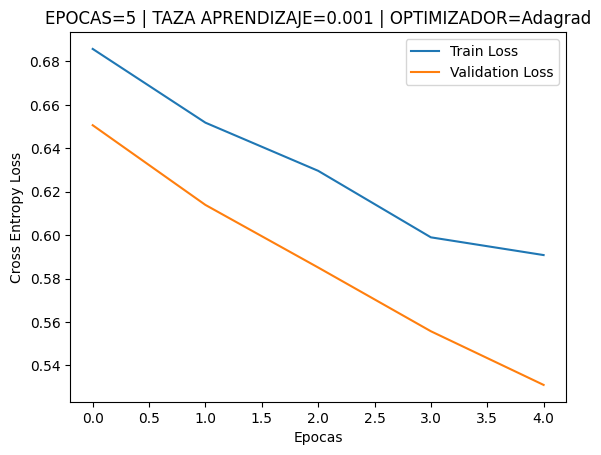

In [56]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6836
Epoch [1/10]	Validation	Loss: 0.6452	Validation Accuracy: 56.5%
Epoch [2/10]	Training [20%]	Loss: 0.6311
Epoch [2/10]	Validation	Loss: 0.5738	Validation Accuracy: 76.5%
Epoch [3/10]	Training [30%]	Loss: 0.5929
Epoch [3/10]	Validation	Loss: 0.5331	Validation Accuracy: 85.5%
Epoch [4/10]	Training [40%]	Loss: 0.5601
Epoch [4/10]	Validation	Loss: 0.5110	Validation Accuracy: 87.0%
Epoch [5/10]	Training [50%]	Loss: 0.5510
Epoch [5/10]	Validation	Loss: 0.5003	Validation Accuracy: 84.5%
Epoch [6/10]	Training [60%]	Loss: 0.5537
Epoch [6/10]	Validation	Loss: 0.4878	Validation Accuracy: 87.5%
Epoch [7/10]	Training [70%]	Loss: 0.5411
Epoch [7/10]	Validation	Loss: 0.4801	Validation Accuracy: 87.0%
Epoch [8/10]	Training [80%]	Loss: 0.5246
Epoch [8/10]	Validation	Loss: 0.4758	Validation Accuracy: 86.5%
Epoch [9/10]	Training [90%]	Loss: 0.5312
Epoch [9/10]	Validation	Loss: 0.4678	Validation Accuracy: 87.0%
Epoch [10/10]	Training [100%]	Loss: 0.5140
Epoch [10/10

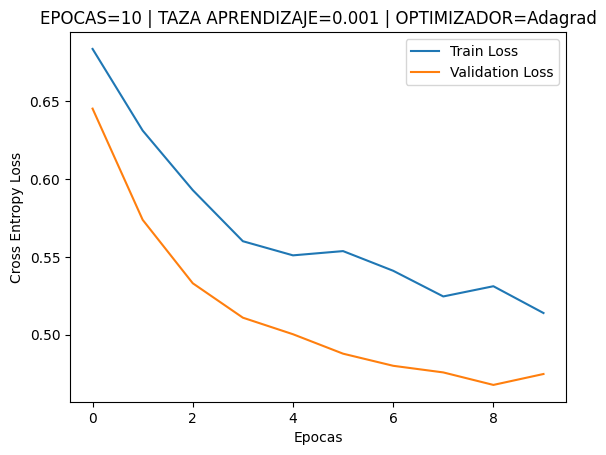

In [57]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6816
Epoch [1/15]	Validation	Loss: 0.6520	Validation Accuracy: 50.5%
Epoch [2/15]	Training [13%]	Loss: 0.6472
Epoch [2/15]	Validation	Loss: 0.6298	Validation Accuracy: 51.5%
Epoch [3/15]	Training [20%]	Loss: 0.6481
Epoch [3/15]	Validation	Loss: 0.6152	Validation Accuracy: 84.5%
Epoch [4/15]	Training [27%]	Loss: 0.6229
Epoch [4/15]	Validation	Loss: 0.5912	Validation Accuracy: 85.0%
Epoch [5/15]	Training [33%]	Loss: 0.6240
Epoch [5/15]	Validation	Loss: 0.5752	Validation Accuracy: 87.5%
Epoch [6/15]	Training [40%]	Loss: 0.6030
Epoch [6/15]	Validation	Loss: 0.5522	Validation Accuracy: 87.5%
Epoch [7/15]	Training [47%]	Loss: 0.5822
Epoch [7/15]	Validation	Loss: 0.5378	Validation Accuracy: 87.5%
Epoch [8/15]	Training [53%]	Loss: 0.5765
Epoch [8/15]	Validation	Loss: 0.5275	Validation Accuracy: 86.5%
Epoch [9/15]	Training [60%]	Loss: 0.5735
Epoch [9/15]	Validation	Loss: 0.5177	Validation Accuracy: 86.5%
Epoch [10/15]	Training [67%]	Loss: 0.5728
Epoch [10/15]	

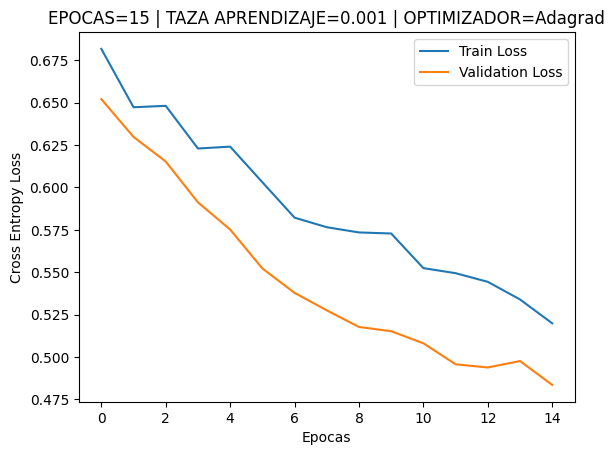

In [58]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6793
Epoch [1/20]	Validation	Loss: 0.6358	Validation Accuracy: 86.0%
Epoch [2/20]	Training [10%]	Loss: 0.6348
Epoch [2/20]	Validation	Loss: 0.5700	Validation Accuracy: 86.0%
Epoch [3/20]	Training [15%]	Loss: 0.6041
Epoch [3/20]	Validation	Loss: 0.5283	Validation Accuracy: 88.5%
Epoch [4/20]	Training [20%]	Loss: 0.5641
Epoch [4/20]	Validation	Loss: 0.5054	Validation Accuracy: 86.0%
Epoch [5/20]	Training [25%]	Loss: 0.5630
Epoch [5/20]	Validation	Loss: 0.4944	Validation Accuracy: 86.5%
Epoch [6/20]	Training [30%]	Loss: 0.5375
Epoch [6/20]	Validation	Loss: 0.4833	Validation Accuracy: 87.5%
Epoch [7/20]	Training [35%]	Loss: 0.5376
Epoch [7/20]	Validation	Loss: 0.4778	Validation Accuracy: 87.0%
Epoch [8/20]	Training [40%]	Loss: 0.5137
Epoch [8/20]	Validation	Loss: 0.4673	Validation Accuracy: 88.5%
Epoch [9/20]	Training [45%]	Loss: 0.5290
Epoch [9/20]	Validation	Loss: 0.4685	Validation Accuracy: 88.0%
Epoch [10/20]	Training [50%]	Loss: 0.5263
Epoch [10/20]	

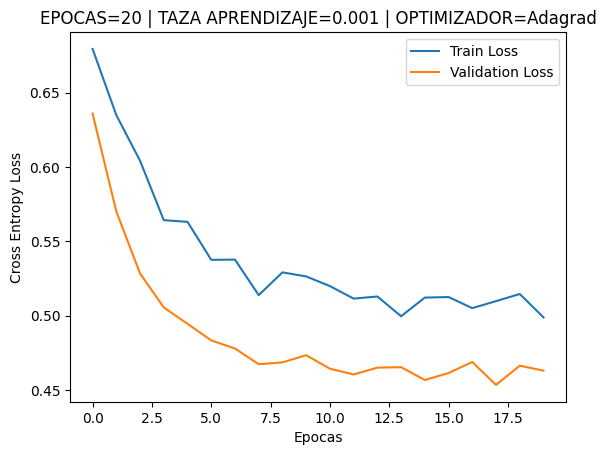

In [59]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.7733
Epoch [1/5]	Validation	Loss: 0.6715	Validation Accuracy: 63.0%
Epoch [2/5]	Training [40%]	Loss: 0.7791
Epoch [2/5]	Validation	Loss: 0.7333	Validation Accuracy: 52.5%
Epoch [3/5]	Training [60%]	Loss: 0.7589
Epoch [3/5]	Validation	Loss: 0.7526	Validation Accuracy: 49.0%
Epoch [4/5]	Training [80%]	Loss: 0.7577
Epoch [4/5]	Validation	Loss: 0.7660	Validation Accuracy: 48.0%
Epoch [5/5]	Training [100%]	Loss: 0.7279
Epoch [5/5]	Validation	Loss: 0.7302	Validation Accuracy: 51.0%
Performance on the test data:
	Loss: 0.7302
	Accuracy: 51.0%
	precision: 51.0%
	recall: 51.0%
	f_score: 51.0%
(0.51, 0.51, 0.51, None)

Confusion Matrix:
[[51 49]
 [49 51]]


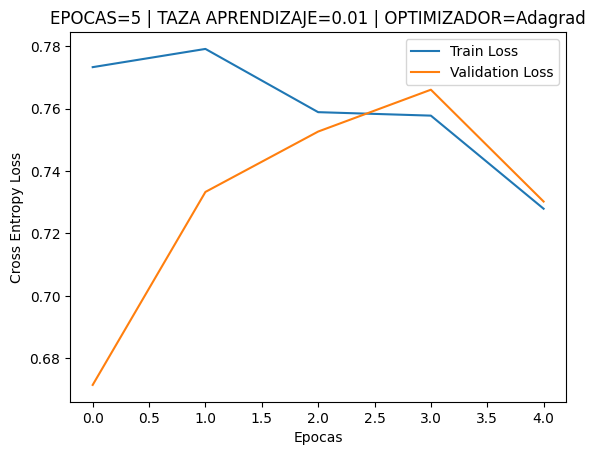

In [60]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.7046
Epoch [1/10]	Validation	Loss: 0.6994	Validation Accuracy: 58.0%
Epoch [2/10]	Training [20%]	Loss: 0.6758
Epoch [2/10]	Validation	Loss: 0.7984	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 0.6367
Epoch [3/10]	Validation	Loss: 0.7731	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 0.6398
Epoch [4/10]	Validation	Loss: 0.7694	Validation Accuracy: 50.0%
Epoch [5/10]	Training [50%]	Loss: 0.6316
Epoch [5/10]	Validation	Loss: 0.7810	Validation Accuracy: 50.0%
Epoch [6/10]	Training [60%]	Loss: 0.6124
Epoch [6/10]	Validation	Loss: 0.8089	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 0.6107
Epoch [7/10]	Validation	Loss: 0.8176	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 0.6043
Epoch [8/10]	Validation	Loss: 0.8206	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 0.5708
Epoch [9/10]	Validation	Loss: 0.8135	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 0.5700
Epoch [10/10

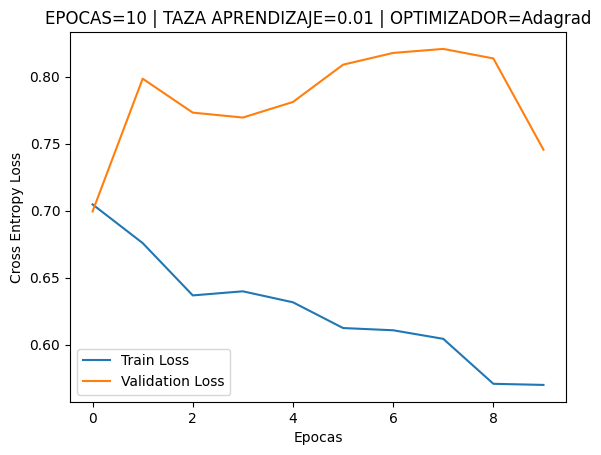

In [61]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.7191
Epoch [1/15]	Validation	Loss: 0.8113	Validation Accuracy: 45.0%
Epoch [2/15]	Training [13%]	Loss: 0.7515
Epoch [2/15]	Validation	Loss: 0.7362	Validation Accuracy: 53.5%
Epoch [3/15]	Training [20%]	Loss: 0.7746
Epoch [3/15]	Validation	Loss: 0.7632	Validation Accuracy: 47.0%
Epoch [4/15]	Training [27%]	Loss: 0.7521
Epoch [4/15]	Validation	Loss: 0.7552	Validation Accuracy: 49.5%
Epoch [5/15]	Training [33%]	Loss: 0.7491
Epoch [5/15]	Validation	Loss: 0.7201	Validation Accuracy: 54.0%
Epoch [6/15]	Training [40%]	Loss: 0.7397
Epoch [6/15]	Validation	Loss: 0.7289	Validation Accuracy: 52.5%
Epoch [7/15]	Training [47%]	Loss: 0.8221
Epoch [7/15]	Validation	Loss: 0.7644	Validation Accuracy: 49.5%
Epoch [8/15]	Training [53%]	Loss: 0.7568
Epoch [8/15]	Validation	Loss: 0.7570	Validation Accuracy: 49.0%
Epoch [9/15]	Training [60%]	Loss: 0.7222
Epoch [9/15]	Validation	Loss: 0.7716	Validation Accuracy: 47.5%
Epoch [10/15]	Training [67%]	Loss: 0.7103
Epoch [10/15]	

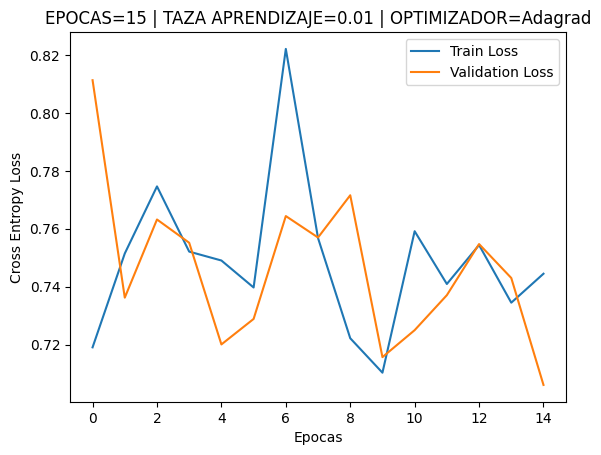

In [62]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6966
Epoch [1/20]	Validation	Loss: 0.6389	Validation Accuracy: 66.0%
Epoch [2/20]	Training [10%]	Loss: 0.6072
Epoch [2/20]	Validation	Loss: 0.7605	Validation Accuracy: 50.0%
Epoch [3/20]	Training [15%]	Loss: 0.7299
Epoch [3/20]	Validation	Loss: 0.7419	Validation Accuracy: 52.0%
Epoch [4/20]	Training [20%]	Loss: 0.7160
Epoch [4/20]	Validation	Loss: 0.7834	Validation Accuracy: 46.0%
Epoch [5/20]	Training [25%]	Loss: 0.7377
Epoch [5/20]	Validation	Loss: 0.7652	Validation Accuracy: 44.0%
Epoch [6/20]	Training [30%]	Loss: 0.7489
Epoch [6/20]	Validation	Loss: 0.7468	Validation Accuracy: 51.5%
Epoch [7/20]	Training [35%]	Loss: 0.7981
Epoch [7/20]	Validation	Loss: 0.7368	Validation Accuracy: 52.0%
Epoch [8/20]	Training [40%]	Loss: 0.7438
Epoch [8/20]	Validation	Loss: 0.7368	Validation Accuracy: 49.5%
Epoch [9/20]	Training [45%]	Loss: 0.7687
Epoch [9/20]	Validation	Loss: 0.7421	Validation Accuracy: 52.5%
Epoch [10/20]	Training [50%]	Loss: 0.6945
Epoch [10/20]	

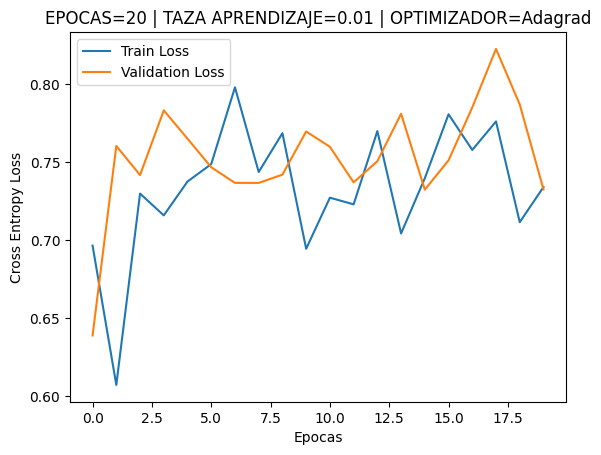

In [63]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6943
Epoch [1/5]	Validation	Loss: 0.6945	Validation Accuracy: 48.5%
Epoch [2/5]	Training [40%]	Loss: 0.6903
Epoch [2/5]	Validation	Loss: 0.6912	Validation Accuracy: 50.5%
Epoch [3/5]	Training [60%]	Loss: 0.6905
Epoch [3/5]	Validation	Loss: 0.6864	Validation Accuracy: 52.5%
Epoch [4/5]	Training [80%]	Loss: 0.6908
Epoch [4/5]	Validation	Loss: 0.6856	Validation Accuracy: 53.5%
Epoch [5/5]	Training [100%]	Loss: 0.6862
Epoch [5/5]	Validation	Loss: 0.6840	Validation Accuracy: 51.0%
Performance on the test data:
	Loss: 0.6840
	Accuracy: 51.0%
	precision: 58.6%
	recall: 51.0%
	f_score: 37.1%
(0.5859106529209621, 0.51, 0.3710691823899371, None)

Confusion Matrix:
[[ 4 96]
 [ 2 98]]


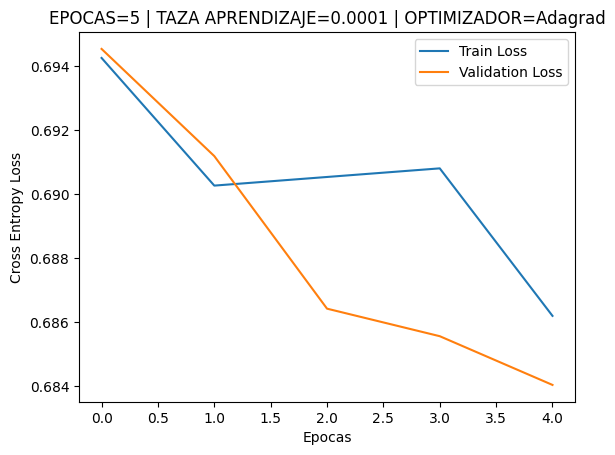

In [64]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6954
Epoch [1/10]	Validation	Loss: 0.6914	Validation Accuracy: 55.5%
Epoch [2/10]	Training [20%]	Loss: 0.6936
Epoch [2/10]	Validation	Loss: 0.6906	Validation Accuracy: 55.5%
Epoch [3/10]	Training [30%]	Loss: 0.6915
Epoch [3/10]	Validation	Loss: 0.6897	Validation Accuracy: 56.0%
Epoch [4/10]	Training [40%]	Loss: 0.6923
Epoch [4/10]	Validation	Loss: 0.6883	Validation Accuracy: 60.0%
Epoch [5/10]	Training [50%]	Loss: 0.6894
Epoch [5/10]	Validation	Loss: 0.6883	Validation Accuracy: 53.0%
Epoch [6/10]	Training [60%]	Loss: 0.6892
Epoch [6/10]	Validation	Loss: 0.6832	Validation Accuracy: 63.5%
Epoch [7/10]	Training [70%]	Loss: 0.6887
Epoch [7/10]	Validation	Loss: 0.6842	Validation Accuracy: 60.0%
Epoch [8/10]	Training [80%]	Loss: 0.6867
Epoch [8/10]	Validation	Loss: 0.6861	Validation Accuracy: 54.0%
Epoch [9/10]	Training [90%]	Loss: 0.6874
Epoch [9/10]	Validation	Loss: 0.6826	Validation Accuracy: 57.0%
Epoch [10/10]	Training [100%]	Loss: 0.6837
Epoch [10/10

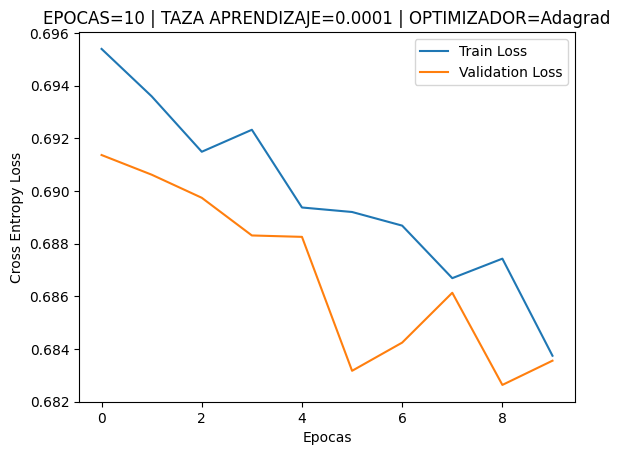

In [65]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6914
Epoch [1/15]	Validation	Loss: 0.6889	Validation Accuracy: 60.0%
Epoch [2/15]	Training [13%]	Loss: 0.6908
Epoch [2/15]	Validation	Loss: 0.6856	Validation Accuracy: 63.5%
Epoch [3/15]	Training [20%]	Loss: 0.6890
Epoch [3/15]	Validation	Loss: 0.6869	Validation Accuracy: 65.5%
Epoch [4/15]	Training [27%]	Loss: 0.6875
Epoch [4/15]	Validation	Loss: 0.6849	Validation Accuracy: 67.0%
Epoch [5/15]	Training [33%]	Loss: 0.6864
Epoch [5/15]	Validation	Loss: 0.6837	Validation Accuracy: 72.5%
Epoch [6/15]	Training [40%]	Loss: 0.6869
Epoch [6/15]	Validation	Loss: 0.6832	Validation Accuracy: 73.5%
Epoch [7/15]	Training [47%]	Loss: 0.6848
Epoch [7/15]	Validation	Loss: 0.6833	Validation Accuracy: 64.0%
Epoch [8/15]	Training [53%]	Loss: 0.6838
Epoch [8/15]	Validation	Loss: 0.6795	Validation Accuracy: 73.0%
Epoch [9/15]	Training [60%]	Loss: 0.6841
Epoch [9/15]	Validation	Loss: 0.6813	Validation Accuracy: 69.5%
Epoch [10/15]	Training [67%]	Loss: 0.6815
Epoch [10/15]	

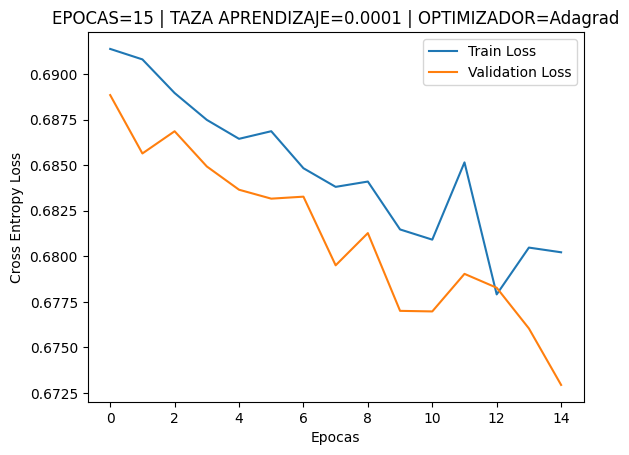

In [66]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = Adagrad

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6920
Epoch [1/20]	Validation	Loss: 0.6885	Validation Accuracy: 55.0%
Epoch [2/20]	Training [10%]	Loss: 0.6885
Epoch [2/20]	Validation	Loss: 0.6881	Validation Accuracy: 56.0%
Epoch [3/20]	Training [15%]	Loss: 0.6873
Epoch [3/20]	Validation	Loss: 0.6831	Validation Accuracy: 60.0%
Epoch [4/20]	Training [20%]	Loss: 0.6879
Epoch [4/20]	Validation	Loss: 0.6870	Validation Accuracy: 54.0%
Epoch [5/20]	Training [25%]	Loss: 0.6856
Epoch [5/20]	Validation	Loss: 0.6849	Validation Accuracy: 52.5%
Epoch [6/20]	Training [30%]	Loss: 0.6852
Epoch [6/20]	Validation	Loss: 0.6839	Validation Accuracy: 55.0%
Epoch [7/20]	Training [35%]	Loss: 0.6830
Epoch [7/20]	Validation	Loss: 0.6837	Validation Accuracy: 55.0%
Epoch [8/20]	Training [40%]	Loss: 0.6834
Epoch [8/20]	Validation	Loss: 0.6819	Validation Accuracy: 52.0%
Epoch [9/20]	Training [45%]	Loss: 0.6841
Epoch [9/20]	Validation	Loss: 0.6798	Validation Accuracy: 51.5%
Epoch [10/20]	Training [50%]	Loss: 0.6835
Epoch [10/20]	

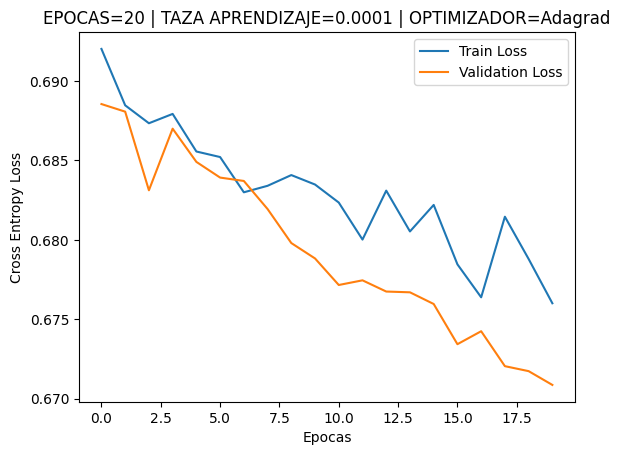

In [67]:
model = Net(num_qubits)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=Adagrad')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------RMSprop--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6996
Epoch [1/5]	Validation	Loss: 0.6012	Validation Accuracy: 73.0%
Epoch [2/5]	Training [40%]	Loss: 0.6843
Epoch [2/5]	Validation	Loss: 0.7224	Validation Accuracy: 53.5%
Epoch [3/5]	Training [60%]	Loss: 0.7608
Epoch [3/5]	Validation	Loss: 0.6229	Validation Accuracy: 68.5%
Epoch [4/5]	Training [80%]	Loss: 0.7225
Epoch [4/5]	Validation	Loss: 0.7464	Validation Accuracy: 42.5%
Epoch [5/5]	Training [100%]	Loss: 0.7020
Epoch [5/5]	Validation	Loss: 0.7038	Validation Accuracy: 58.5%
Performance on the test data:
	Loss: 0.7038
	Accuracy: 58.5%
	precision: 58.5%
	recall: 58.5%
	f_score: 58.5%
(0.5850765689120208, 0.585, 0.5849066039858969, None)

Confusion Matrix:
[[57 43]
 [40 60]]


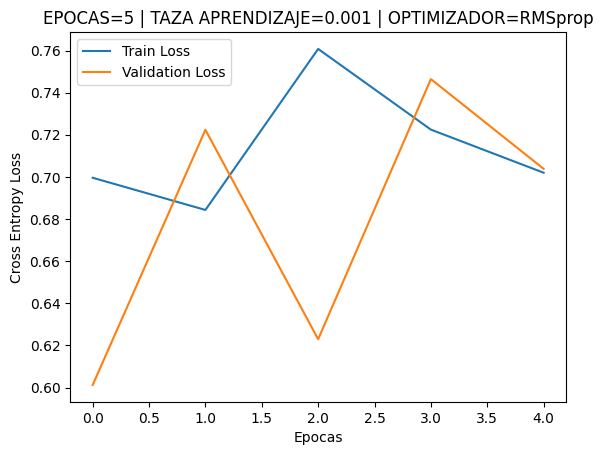

In [68]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.7105
Epoch [1/10]	Validation	Loss: 0.7325	Validation Accuracy: 53.5%
Epoch [2/10]	Training [20%]	Loss: 0.6433
Epoch [2/10]	Validation	Loss: 0.7263	Validation Accuracy: 55.5%
Epoch [3/10]	Training [30%]	Loss: 0.7036
Epoch [3/10]	Validation	Loss: 0.8135	Validation Accuracy: 50.0%
Epoch [4/10]	Training [40%]	Loss: 0.7009
Epoch [4/10]	Validation	Loss: 0.7889	Validation Accuracy: 47.5%
Epoch [5/10]	Training [50%]	Loss: 0.7006
Epoch [5/10]	Validation	Loss: 0.9752	Validation Accuracy: 20.0%
Epoch [6/10]	Training [60%]	Loss: 0.6535
Epoch [6/10]	Validation	Loss: 0.8852	Validation Accuracy: 30.0%
Epoch [7/10]	Training [70%]	Loss: 0.7151
Epoch [7/10]	Validation	Loss: 0.8922	Validation Accuracy: 26.5%
Epoch [8/10]	Training [80%]	Loss: 0.7295
Epoch [8/10]	Validation	Loss: 0.7503	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 0.7249
Epoch [9/10]	Validation	Loss: 0.9435	Validation Accuracy: 20.0%
Epoch [10/10]	Training [100%]	Loss: 0.6857
Epoch [10/10

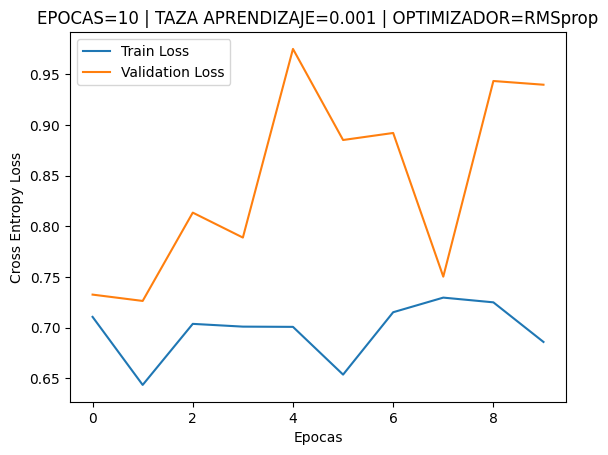

In [69]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6956
Epoch [1/15]	Validation	Loss: 0.6840	Validation Accuracy: 51.5%
Epoch [2/15]	Training [13%]	Loss: 0.6501
Epoch [2/15]	Validation	Loss: 0.5298	Validation Accuracy: 79.5%
Epoch [3/15]	Training [20%]	Loss: 0.5438
Epoch [3/15]	Validation	Loss: 0.5662	Validation Accuracy: 73.5%
Epoch [4/15]	Training [27%]	Loss: 0.5247
Epoch [4/15]	Validation	Loss: 0.5479	Validation Accuracy: 76.0%
Epoch [5/15]	Training [33%]	Loss: 0.5049
Epoch [5/15]	Validation	Loss: 0.4998	Validation Accuracy: 83.0%
Epoch [6/15]	Training [40%]	Loss: 0.5127
Epoch [6/15]	Validation	Loss: 0.5331	Validation Accuracy: 79.5%
Epoch [7/15]	Training [47%]	Loss: 0.4763
Epoch [7/15]	Validation	Loss: 0.4593	Validation Accuracy: 83.0%
Epoch [8/15]	Training [53%]	Loss: 0.4429
Epoch [8/15]	Validation	Loss: 0.4810	Validation Accuracy: 82.5%
Epoch [9/15]	Training [60%]	Loss: 0.4570
Epoch [9/15]	Validation	Loss: 0.4641	Validation Accuracy: 84.5%
Epoch [10/15]	Training [67%]	Loss: 0.4260
Epoch [10/15]	

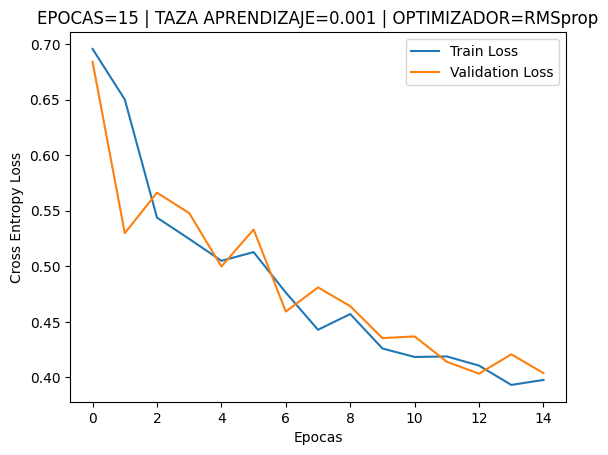

In [70]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.7627
Epoch [1/20]	Validation	Loss: 0.7837	Validation Accuracy: 44.0%
Epoch [2/20]	Training [10%]	Loss: 0.7421
Epoch [2/20]	Validation	Loss: 0.7707	Validation Accuracy: 45.5%
Epoch [3/20]	Training [15%]	Loss: 0.7557
Epoch [3/20]	Validation	Loss: 0.7326	Validation Accuracy: 51.5%
Epoch [4/20]	Training [20%]	Loss: 0.7965
Epoch [4/20]	Validation	Loss: 0.7459	Validation Accuracy: 51.5%
Epoch [5/20]	Training [25%]	Loss: 0.7251
Epoch [5/20]	Validation	Loss: 0.7226	Validation Accuracy: 54.5%
Epoch [6/20]	Training [30%]	Loss: 0.7813
Epoch [6/20]	Validation	Loss: 0.7621	Validation Accuracy: 48.0%
Epoch [7/20]	Training [35%]	Loss: 0.7904
Epoch [7/20]	Validation	Loss: 0.7562	Validation Accuracy: 48.0%
Epoch [8/20]	Training [40%]	Loss: 0.7457
Epoch [8/20]	Validation	Loss: 0.6056	Validation Accuracy: 71.0%
Epoch [9/20]	Training [45%]	Loss: 0.7862
Epoch [9/20]	Validation	Loss: 0.7469	Validation Accuracy: 49.0%
Epoch [10/20]	Training [50%]	Loss: 0.7801
Epoch [10/20]	

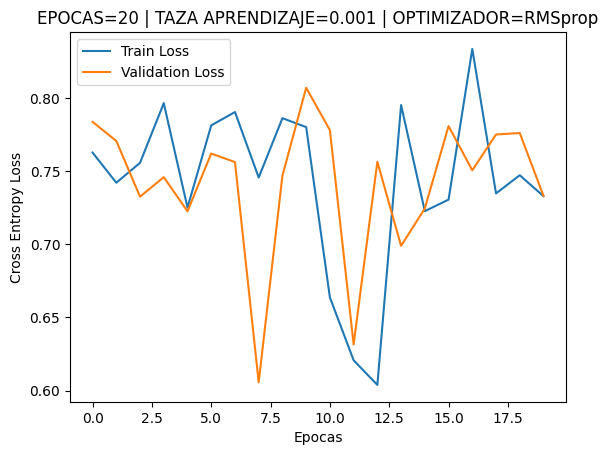

In [71]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.7647
Epoch [1/5]	Validation	Loss: 0.8168	Validation Accuracy: 40.0%
Epoch [2/5]	Training [40%]	Loss: 0.7512
Epoch [2/5]	Validation	Loss: 0.7020	Validation Accuracy: 58.0%
Epoch [3/5]	Training [60%]	Loss: 0.7804
Epoch [3/5]	Validation	Loss: 0.7333	Validation Accuracy: 58.0%
Epoch [4/5]	Training [80%]	Loss: 0.7585
Epoch [4/5]	Validation	Loss: 0.7494	Validation Accuracy: 49.5%
Epoch [5/5]	Training [100%]	Loss: 0.7152
Epoch [5/5]	Validation	Loss: 0.7327	Validation Accuracy: 52.5%
Performance on the test data:
	Loss: 0.7327
	Accuracy: 52.5%
	precision: 52.6%
	recall: 52.5%
	f_score: 52.2%
(0.5257440016476161, 0.525, 0.5215431492533555, None)

Confusion Matrix:
[[44 56]
 [39 61]]


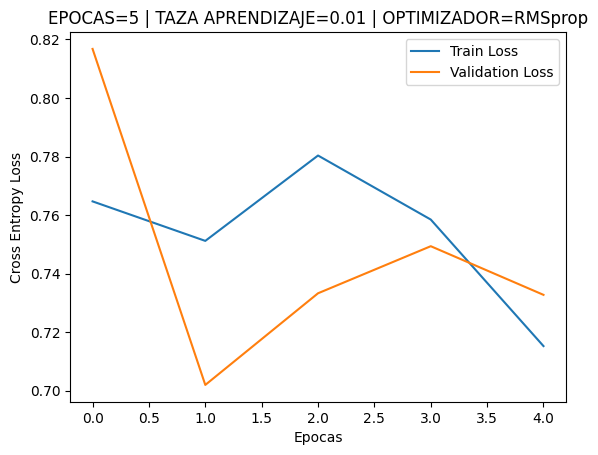

In [72]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.7729
Epoch [1/10]	Validation	Loss: 0.7049	Validation Accuracy: 56.0%
Epoch [2/10]	Training [20%]	Loss: 0.8011
Epoch [2/10]	Validation	Loss: 0.7431	Validation Accuracy: 50.0%
Epoch [3/10]	Training [30%]	Loss: 0.7500
Epoch [3/10]	Validation	Loss: 0.7568	Validation Accuracy: 53.5%
Epoch [4/10]	Training [40%]	Loss: 0.7208
Epoch [4/10]	Validation	Loss: 0.8428	Validation Accuracy: 42.0%
Epoch [5/10]	Training [50%]	Loss: 0.7353
Epoch [5/10]	Validation	Loss: 0.6884	Validation Accuracy: 54.5%
Epoch [6/10]	Training [60%]	Loss: 0.7580
Epoch [6/10]	Validation	Loss: 0.8132	Validation Accuracy: 50.0%
Epoch [7/10]	Training [70%]	Loss: 0.7348
Epoch [7/10]	Validation	Loss: 0.7315	Validation Accuracy: 50.0%
Epoch [8/10]	Training [80%]	Loss: 0.7783
Epoch [8/10]	Validation	Loss: 0.7976	Validation Accuracy: 50.0%
Epoch [9/10]	Training [90%]	Loss: 0.7377
Epoch [9/10]	Validation	Loss: 0.7811	Validation Accuracy: 50.0%
Epoch [10/10]	Training [100%]	Loss: 0.7208
Epoch [10/10

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


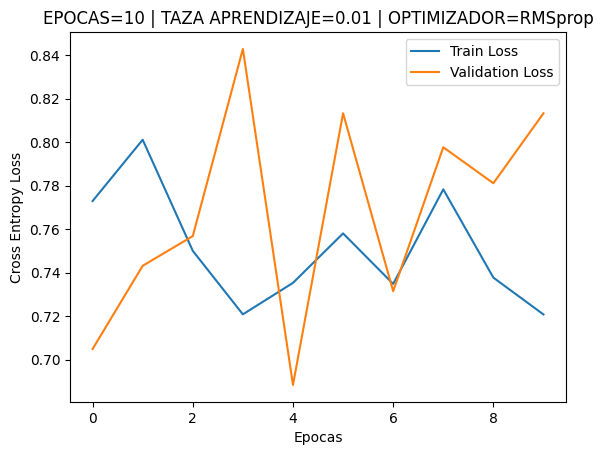

In [73]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.7405
Epoch [1/15]	Validation	Loss: 0.6996	Validation Accuracy: 55.0%
Epoch [2/15]	Training [13%]	Loss: 0.7559
Epoch [2/15]	Validation	Loss: 0.7611	Validation Accuracy: 52.5%
Epoch [3/15]	Training [20%]	Loss: 0.7645
Epoch [3/15]	Validation	Loss: 0.7051	Validation Accuracy: 55.5%
Epoch [4/15]	Training [27%]	Loss: 0.7843
Epoch [4/15]	Validation	Loss: 0.7105	Validation Accuracy: 56.0%
Epoch [5/15]	Training [33%]	Loss: 0.7812
Epoch [5/15]	Validation	Loss: 0.7323	Validation Accuracy: 50.5%
Epoch [6/15]	Training [40%]	Loss: 0.7357
Epoch [6/15]	Validation	Loss: 0.7576	Validation Accuracy: 52.0%
Epoch [7/15]	Training [47%]	Loss: 0.7607
Epoch [7/15]	Validation	Loss: 0.7740	Validation Accuracy: 46.0%
Epoch [8/15]	Training [53%]	Loss: 0.7769
Epoch [8/15]	Validation	Loss: 0.7379	Validation Accuracy: 52.0%
Epoch [9/15]	Training [60%]	Loss: 0.7384
Epoch [9/15]	Validation	Loss: 0.7773	Validation Accuracy: 46.5%
Epoch [10/15]	Training [67%]	Loss: 0.7853
Epoch [10/15]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


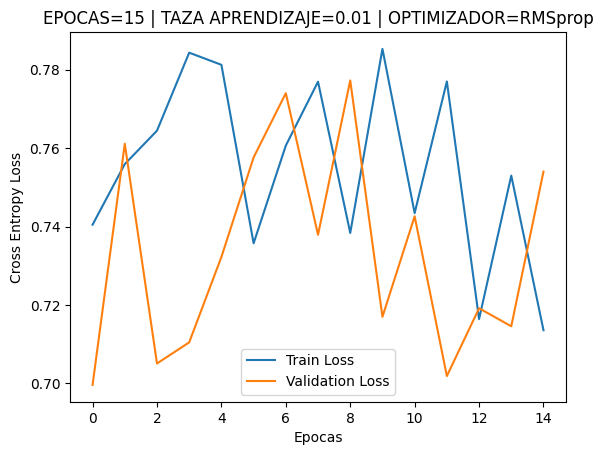

In [74]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6963
Epoch [1/20]	Validation	Loss: 0.7697	Validation Accuracy: 45.5%
Epoch [2/20]	Training [10%]	Loss: 0.7763
Epoch [2/20]	Validation	Loss: 0.7565	Validation Accuracy: 48.5%
Epoch [3/20]	Training [15%]	Loss: 0.7472
Epoch [3/20]	Validation	Loss: 0.6832	Validation Accuracy: 56.0%
Epoch [4/20]	Training [20%]	Loss: 0.7429
Epoch [4/20]	Validation	Loss: 0.7322	Validation Accuracy: 52.5%
Epoch [5/20]	Training [25%]	Loss: 0.7453
Epoch [5/20]	Validation	Loss: 0.7571	Validation Accuracy: 48.0%
Epoch [6/20]	Training [30%]	Loss: 0.7641
Epoch [6/20]	Validation	Loss: 0.7511	Validation Accuracy: 49.0%
Epoch [7/20]	Training [35%]	Loss: 0.7608
Epoch [7/20]	Validation	Loss: 0.7820	Validation Accuracy: 47.5%
Epoch [8/20]	Training [40%]	Loss: 0.7391
Epoch [8/20]	Validation	Loss: 0.7589	Validation Accuracy: 51.5%
Epoch [9/20]	Training [45%]	Loss: 0.7833
Epoch [9/20]	Validation	Loss: 0.8114	Validation Accuracy: 45.5%
Epoch [10/20]	Training [50%]	Loss: 0.7474
Epoch [10/20]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


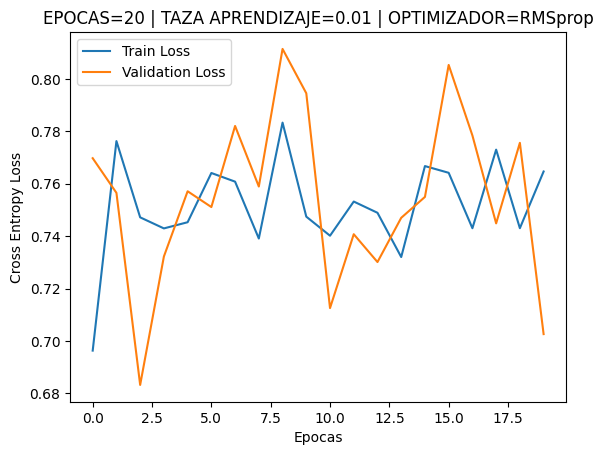

In [75]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6777
Epoch [1/5]	Validation	Loss: 0.6210	Validation Accuracy: 65.5%
Epoch [2/5]	Training [40%]	Loss: 0.6221
Epoch [2/5]	Validation	Loss: 0.5476	Validation Accuracy: 85.0%
Epoch [3/5]	Training [60%]	Loss: 0.5978
Epoch [3/5]	Validation	Loss: 0.5152	Validation Accuracy: 83.5%
Epoch [4/5]	Training [80%]	Loss: 0.5486
Epoch [4/5]	Validation	Loss: 0.4828	Validation Accuracy: 85.5%
Epoch [5/5]	Training [100%]	Loss: 0.5464
Epoch [5/5]	Validation	Loss: 0.4760	Validation Accuracy: 86.0%
Performance on the test data:
	Loss: 0.4760
	Accuracy: 86.0%
	precision: 88.2%
	recall: 86.0%
	f_score: 85.8%
(0.8820033955857385, 0.86, 0.8579545454545454, None)

Confusion Matrix:
[[98  2]
 [26 74]]


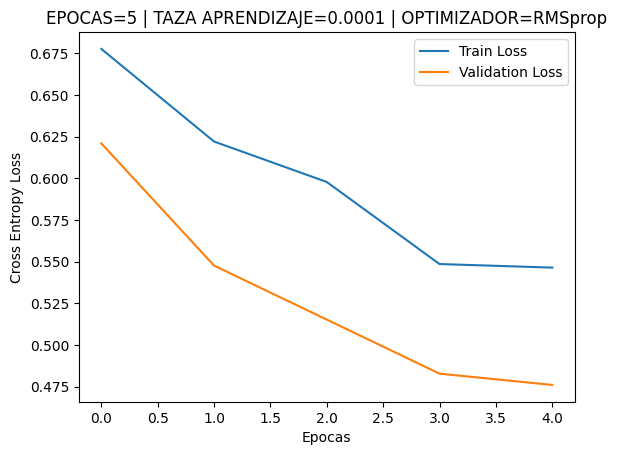

In [76]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6777
Epoch [1/10]	Validation	Loss: 0.6487	Validation Accuracy: 83.5%
Epoch [2/10]	Training [20%]	Loss: 0.6491
Epoch [2/10]	Validation	Loss: 0.5946	Validation Accuracy: 84.5%
Epoch [3/10]	Training [30%]	Loss: 0.6119
Epoch [3/10]	Validation	Loss: 0.5521	Validation Accuracy: 85.5%
Epoch [4/10]	Training [40%]	Loss: 0.5924
Epoch [4/10]	Validation	Loss: 0.5222	Validation Accuracy: 86.0%
Epoch [5/10]	Training [50%]	Loss: 0.5596
Epoch [5/10]	Validation	Loss: 0.5314	Validation Accuracy: 77.0%
Epoch [6/10]	Training [60%]	Loss: 0.5594
Epoch [6/10]	Validation	Loss: 0.4824	Validation Accuracy: 88.5%
Epoch [7/10]	Training [70%]	Loss: 0.5313
Epoch [7/10]	Validation	Loss: 0.4736	Validation Accuracy: 89.5%
Epoch [8/10]	Training [80%]	Loss: 0.5115
Epoch [8/10]	Validation	Loss: 0.5480	Validation Accuracy: 72.0%
Epoch [9/10]	Training [90%]	Loss: 0.4939
Epoch [9/10]	Validation	Loss: 0.4439	Validation Accuracy: 90.0%
Epoch [10/10]	Training [100%]	Loss: 0.4979
Epoch [10/10

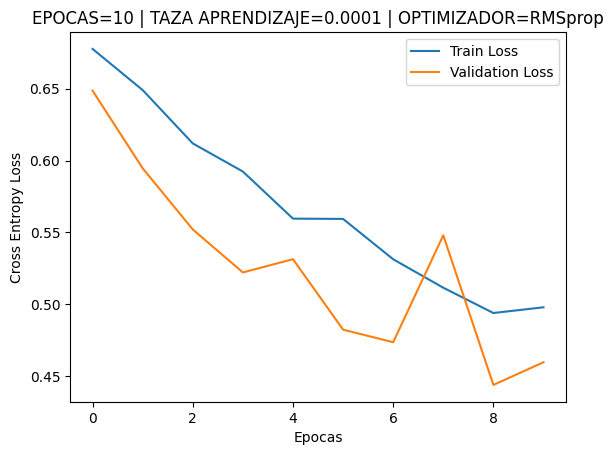

In [77]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.6746
Epoch [1/15]	Validation	Loss: 0.6203	Validation Accuracy: 81.5%
Epoch [2/15]	Training [13%]	Loss: 0.6310
Epoch [2/15]	Validation	Loss: 0.5888	Validation Accuracy: 76.5%
Epoch [3/15]	Training [20%]	Loss: 0.5874
Epoch [3/15]	Validation	Loss: 0.5111	Validation Accuracy: 86.0%
Epoch [4/15]	Training [27%]	Loss: 0.5451
Epoch [4/15]	Validation	Loss: 0.5417	Validation Accuracy: 74.5%
Epoch [5/15]	Training [33%]	Loss: 0.5480
Epoch [5/15]	Validation	Loss: 0.5177	Validation Accuracy: 75.0%
Epoch [6/15]	Training [40%]	Loss: 0.5288
Epoch [6/15]	Validation	Loss: 0.4797	Validation Accuracy: 82.5%
Epoch [7/15]	Training [47%]	Loss: 0.5241
Epoch [7/15]	Validation	Loss: 0.4611	Validation Accuracy: 90.5%
Epoch [8/15]	Training [53%]	Loss: 0.5082
Epoch [8/15]	Validation	Loss: 0.4585	Validation Accuracy: 88.0%
Epoch [9/15]	Training [60%]	Loss: 0.5118
Epoch [9/15]	Validation	Loss: 0.4672	Validation Accuracy: 83.5%
Epoch [10/15]	Training [67%]	Loss: 0.4862
Epoch [10/15]	

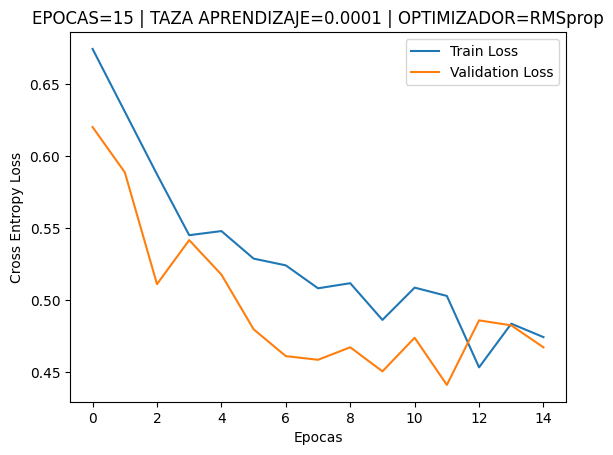

In [78]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = RMSprop

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6782
Epoch [1/20]	Validation	Loss: 0.6231	Validation Accuracy: 87.0%
Epoch [2/20]	Training [10%]	Loss: 0.6221
Epoch [2/20]	Validation	Loss: 0.5715	Validation Accuracy: 77.0%
Epoch [3/20]	Training [15%]	Loss: 0.5759
Epoch [3/20]	Validation	Loss: 0.5135	Validation Accuracy: 88.0%
Epoch [4/20]	Training [20%]	Loss: 0.5705
Epoch [4/20]	Validation	Loss: 0.5055	Validation Accuracy: 89.5%
Epoch [5/20]	Training [25%]	Loss: 0.5639
Epoch [5/20]	Validation	Loss: 0.4979	Validation Accuracy: 82.0%
Epoch [6/20]	Training [30%]	Loss: 0.5302
Epoch [6/20]	Validation	Loss: 0.4757	Validation Accuracy: 89.5%
Epoch [7/20]	Training [35%]	Loss: 0.5283
Epoch [7/20]	Validation	Loss: 0.5110	Validation Accuracy: 76.5%
Epoch [8/20]	Training [40%]	Loss: 0.4893
Epoch [8/20]	Validation	Loss: 0.4570	Validation Accuracy: 87.5%
Epoch [9/20]	Training [45%]	Loss: 0.4943
Epoch [9/20]	Validation	Loss: 0.4451	Validation Accuracy: 89.0%
Epoch [10/20]	Training [50%]	Loss: 0.4846
Epoch [10/20]	

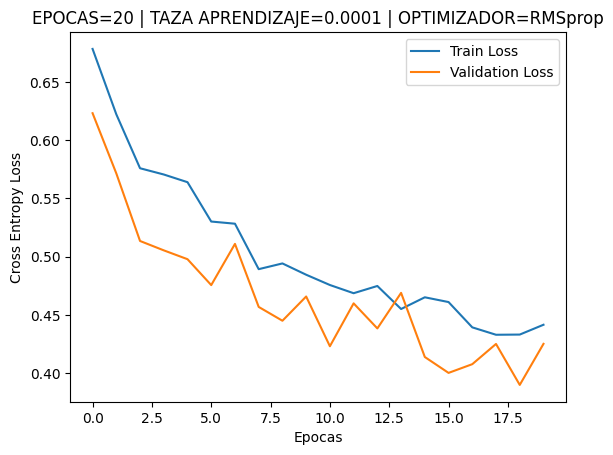

In [79]:
model = Net(num_qubits)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)# Forward pass
        loss = loss_func(output, target)# Calculating loss
        loss.backward()# Backward pass
        optimizer.step()# Optimize the weights
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=RMSprop')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

------------------------------------LBFGS--------------------------------------

EPOCHS=5 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.3242
Epoch [1/5]	Validation	Loss: 0.6929	Validation Accuracy: 54.0%
Epoch [2/5]	Training [40%]	Loss: 0.6655
Epoch [2/5]	Validation	Loss: 0.6928	Validation Accuracy: 49.5%
Epoch [3/5]	Training [60%]	Loss: 0.6862
Epoch [3/5]	Validation	Loss: 0.6906	Validation Accuracy: 54.5%
Epoch [4/5]	Training [80%]	Loss: 0.7288
Epoch [4/5]	Validation	Loss: 0.6909	Validation Accuracy: 53.5%
Epoch [5/5]	Training [100%]	Loss: 0.6753
Epoch [5/5]	Validation	Loss: 0.6925	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 0.6925
	Accuracy: 50.0%
	precision: 50.0%
	recall: 50.0%
	f_score: 44.3%
(0.5, 0.5, 0.4429590017825312, None)

Confusion Matrix:
[[82 18]
 [82 18]]


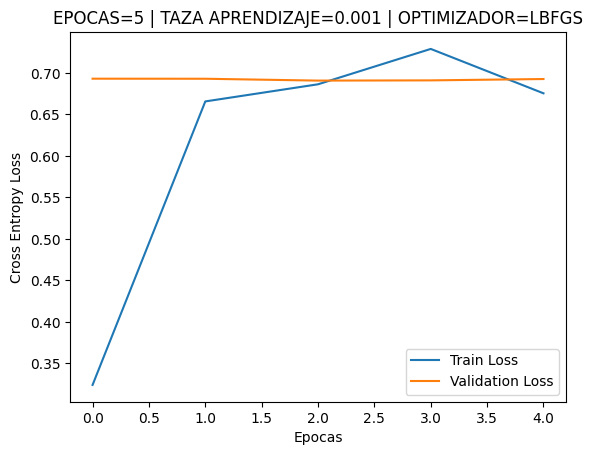

In [80]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.6773
Epoch [1/10]	Validation	Loss: 0.6914	Validation Accuracy: 53.0%
Epoch [2/10]	Training [20%]	Loss: 0.7083
Epoch [2/10]	Validation	Loss: 0.6907	Validation Accuracy: 55.5%
Epoch [3/10]	Training [30%]	Loss: 0.6675
Epoch [3/10]	Validation	Loss: 0.6920	Validation Accuracy: 53.0%
Epoch [4/10]	Training [40%]	Loss: 0.6685
Epoch [4/10]	Validation	Loss: 0.6923	Validation Accuracy: 52.5%
Epoch [5/10]	Training [50%]	Loss: 0.7113
Epoch [5/10]	Validation	Loss: 0.6911	Validation Accuracy: 51.5%
Epoch [6/10]	Training [60%]	Loss: 0.7093
Epoch [6/10]	Validation	Loss: 0.6920	Validation Accuracy: 50.5%
Epoch [7/10]	Training [70%]	Loss: 0.6862
Epoch [7/10]	Validation	Loss: 0.6923	Validation Accuracy: 50.5%
Epoch [8/10]	Training [80%]	Loss: 0.6724
Epoch [8/10]	Validation	Loss: 0.6903	Validation Accuracy: 52.5%
Epoch [9/10]	Training [90%]	Loss: 0.7012
Epoch [9/10]	Validation	Loss: 0.6916	Validation Accuracy: 53.0%
Epoch [10/10]	Training [100%]	Loss: 0.6792
Epoch [10/10

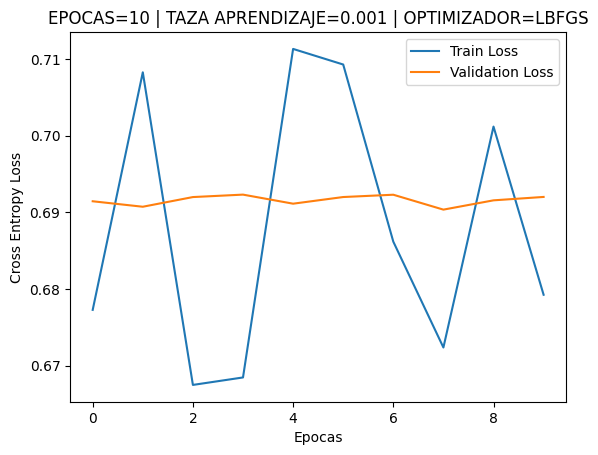

In [81]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.7002
Epoch [1/15]	Validation	Loss: 0.6965	Validation Accuracy: 48.5%
Epoch [2/15]	Training [13%]	Loss: 0.6763
Epoch [2/15]	Validation	Loss: 0.6965	Validation Accuracy: 49.0%
Epoch [3/15]	Training [20%]	Loss: 0.6425
Epoch [3/15]	Validation	Loss: 0.6947	Validation Accuracy: 49.0%
Epoch [4/15]	Training [27%]	Loss: 0.6902
Epoch [4/15]	Validation	Loss: 0.6987	Validation Accuracy: 46.0%
Epoch [5/15]	Training [33%]	Loss: 0.6626
Epoch [5/15]	Validation	Loss: 0.6964	Validation Accuracy: 44.0%
Epoch [6/15]	Training [40%]	Loss: 0.6397
Epoch [6/15]	Validation	Loss: 0.6975	Validation Accuracy: 46.5%
Epoch [7/15]	Training [47%]	Loss: 0.7052
Epoch [7/15]	Validation	Loss: 0.6952	Validation Accuracy: 48.5%
Epoch [8/15]	Training [53%]	Loss: 0.6655
Epoch [8/15]	Validation	Loss: 0.6970	Validation Accuracy: 44.5%
Epoch [9/15]	Training [60%]	Loss: 0.7002
Epoch [9/15]	Validation	Loss: 0.6953	Validation Accuracy: 49.0%
Epoch [10/15]	Training [67%]	Loss: 0.7195
Epoch [10/15]	

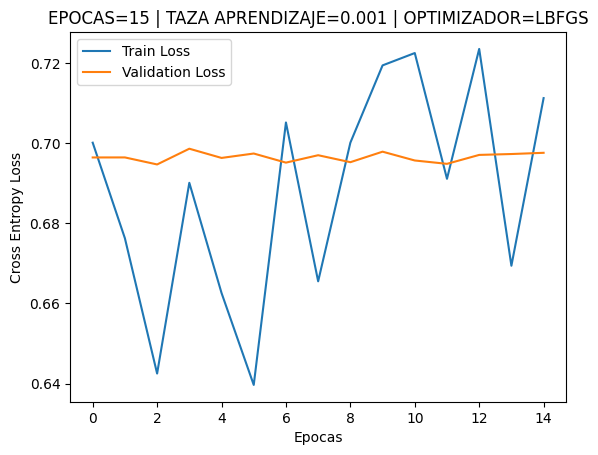

In [82]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.6694
Epoch [1/20]	Validation	Loss: 0.6953	Validation Accuracy: 49.5%
Epoch [2/20]	Training [10%]	Loss: 0.6704
Epoch [2/20]	Validation	Loss: 0.6973	Validation Accuracy: 46.5%
Epoch [3/20]	Training [15%]	Loss: 0.7052
Epoch [3/20]	Validation	Loss: 0.6981	Validation Accuracy: 41.5%
Epoch [4/20]	Training [20%]	Loss: 0.7267
Epoch [4/20]	Validation	Loss: 0.6967	Validation Accuracy: 39.0%
Epoch [5/20]	Training [25%]	Loss: 0.7267
Epoch [5/20]	Validation	Loss: 0.6936	Validation Accuracy: 51.5%
Epoch [6/20]	Training [30%]	Loss: 0.6783
Epoch [6/20]	Validation	Loss: 0.6964	Validation Accuracy: 45.0%
Epoch [7/20]	Training [35%]	Loss: 0.7174
Epoch [7/20]	Validation	Loss: 0.6960	Validation Accuracy: 45.5%
Epoch [8/20]	Training [40%]	Loss: 0.6951
Epoch [8/20]	Validation	Loss: 0.6973	Validation Accuracy: 39.0%
Epoch [9/20]	Training [45%]	Loss: 0.7062
Epoch [9/20]	Validation	Loss: 0.6954	Validation Accuracy: 44.5%
Epoch [10/20]	Training [50%]	Loss: 0.6714
Epoch [10/20]	

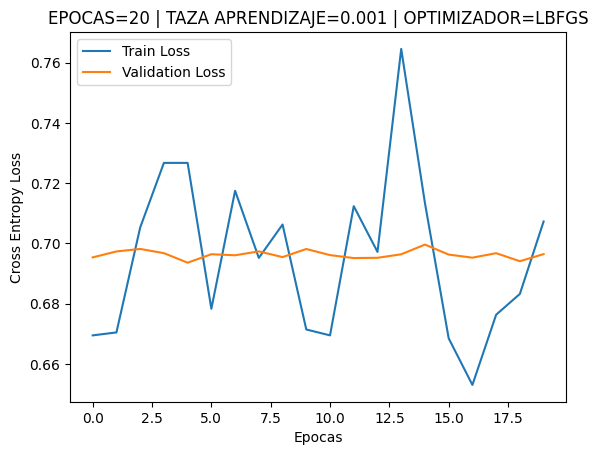

In [83]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.01 ******************

EPOCHS=5 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.7062
Epoch [1/5]	Validation	Loss: 0.6945	Validation Accuracy: 45.5%
Epoch [2/5]	Training [40%]	Loss: 0.7113
Epoch [2/5]	Validation	Loss: 0.6953	Validation Accuracy: 46.0%
Epoch [3/5]	Training [60%]	Loss: 0.7174
Epoch [3/5]	Validation	Loss: 0.6963	Validation Accuracy: 43.0%
Epoch [4/5]	Training [80%]	Loss: 0.6921
Epoch [4/5]	Validation	Loss: 0.6951	Validation Accuracy: 49.0%
Epoch [5/5]	Training [100%]	Loss: 0.7267
Epoch [5/5]	Validation	Loss: 0.6945	Validation Accuracy: 44.0%
Performance on the test data:
	Loss: 0.6945
	Accuracy: 44.0%
	precision: 44.0%
	recall: 44.0%
	f_score: 44.0%
(0.4399759903961584, 0.44, 0.43994399439943993, None)

Confusion Matrix:
[[43 57]
 [55 45]]


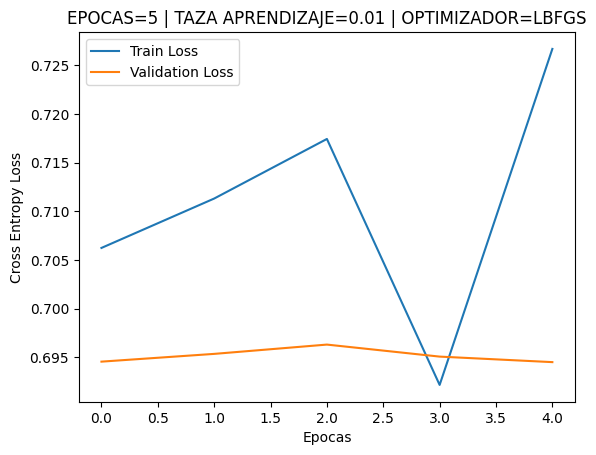

In [84]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.7032
Epoch [1/10]	Validation	Loss: 0.6933	Validation Accuracy: 49.5%
Epoch [2/10]	Training [20%]	Loss: 0.6763
Epoch [2/10]	Validation	Loss: 0.6947	Validation Accuracy: 49.5%
Epoch [3/10]	Training [30%]	Loss: 0.6832
Epoch [3/10]	Validation	Loss: 0.6932	Validation Accuracy: 51.5%
Epoch [4/10]	Training [40%]	Loss: 0.6842
Epoch [4/10]	Validation	Loss: 0.6945	Validation Accuracy: 48.5%
Epoch [5/10]	Training [50%]	Loss: 0.6872
Epoch [5/10]	Validation	Loss: 0.6916	Validation Accuracy: 52.5%
Epoch [6/10]	Training [60%]	Loss: 0.7093
Epoch [6/10]	Validation	Loss: 0.6938	Validation Accuracy: 46.5%
Epoch [7/10]	Training [70%]	Loss: 0.6962
Epoch [7/10]	Validation	Loss: 0.6930	Validation Accuracy: 53.5%
Epoch [8/10]	Training [80%]	Loss: 0.6872
Epoch [8/10]	Validation	Loss: 0.6935	Validation Accuracy: 53.0%
Epoch [9/10]	Training [90%]	Loss: 0.7083
Epoch [9/10]	Validation	Loss: 0.6941	Validation Accuracy: 51.0%
Epoch [10/10]	Training [100%]	Loss: 0.7083
Epoch [10/10

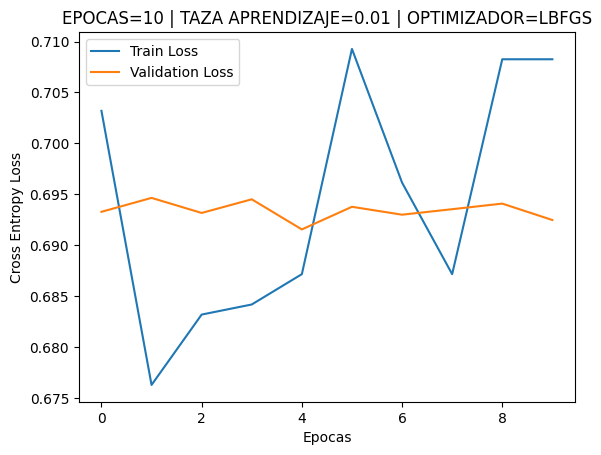

In [85]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.7012
Epoch [1/15]	Validation	Loss: 0.7060	Validation Accuracy: 50.0%
Epoch [2/15]	Training [13%]	Loss: 0.5219
Epoch [2/15]	Validation	Loss: 0.7057	Validation Accuracy: 50.0%
Epoch [3/15]	Training [20%]	Loss: 0.4948
Epoch [3/15]	Validation	Loss: 0.7076	Validation Accuracy: 50.0%
Epoch [4/15]	Training [27%]	Loss: 0.5114
Epoch [4/15]	Validation	Loss: 0.7085	Validation Accuracy: 50.0%
Epoch [5/15]	Training [33%]	Loss: 0.9154
Epoch [5/15]	Validation	Loss: 0.7084	Validation Accuracy: 50.0%
Epoch [6/15]	Training [40%]	Loss: 0.5074
Epoch [6/15]	Validation	Loss: 0.7063	Validation Accuracy: 50.0%
Epoch [7/15]	Training [47%]	Loss: 0.5203
Epoch [7/15]	Validation	Loss: 0.7067	Validation Accuracy: 50.0%
Epoch [8/15]	Training [53%]	Loss: 0.5203
Epoch [8/15]	Validation	Loss: 0.7069	Validation Accuracy: 50.0%
Epoch [9/15]	Training [60%]	Loss: 0.8975
Epoch [9/15]	Validation	Loss: 0.7073	Validation Accuracy: 50.0%
Epoch [10/15]	Training [67%]	Loss: 0.5162
Epoch [10/15]	

C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sergio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


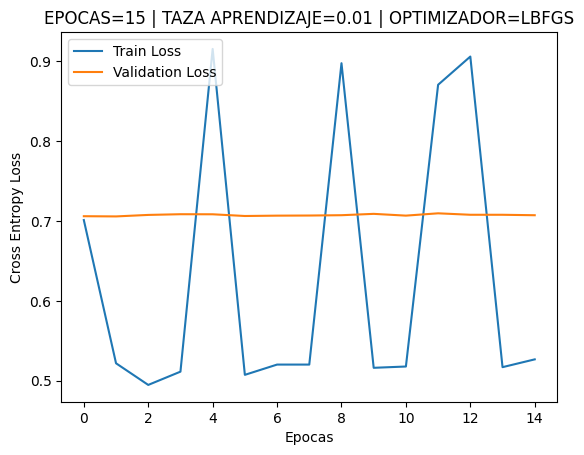

In [86]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.01 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.5106
Epoch [1/20]	Validation	Loss: 0.6959	Validation Accuracy: 44.0%
Epoch [2/20]	Training [10%]	Loss: 0.6862
Epoch [2/20]	Validation	Loss: 0.6936	Validation Accuracy: 47.5%
Epoch [3/20]	Training [15%]	Loss: 0.6962
Epoch [3/20]	Validation	Loss: 0.6958	Validation Accuracy: 44.0%
Epoch [4/20]	Training [20%]	Loss: 0.6743
Epoch [4/20]	Validation	Loss: 0.6962	Validation Accuracy: 43.5%
Epoch [5/20]	Training [25%]	Loss: 0.7022
Epoch [5/20]	Validation	Loss: 0.6920	Validation Accuracy: 52.0%
Epoch [6/20]	Training [30%]	Loss: 0.7093
Epoch [6/20]	Validation	Loss: 0.6940	Validation Accuracy: 48.0%
Epoch [7/20]	Training [35%]	Loss: 0.6872
Epoch [7/20]	Validation	Loss: 0.6946	Validation Accuracy: 45.5%
Epoch [8/20]	Training [40%]	Loss: 0.6832
Epoch [8/20]	Validation	Loss: 0.6946	Validation Accuracy: 48.0%
Epoch [9/20]	Training [45%]	Loss: 0.7062
Epoch [9/20]	Validation	Loss: 0.6943	Validation Accuracy: 48.0%
Epoch [10/20]	Training [50%]	Loss: 0.7062
Epoch [10/20]	

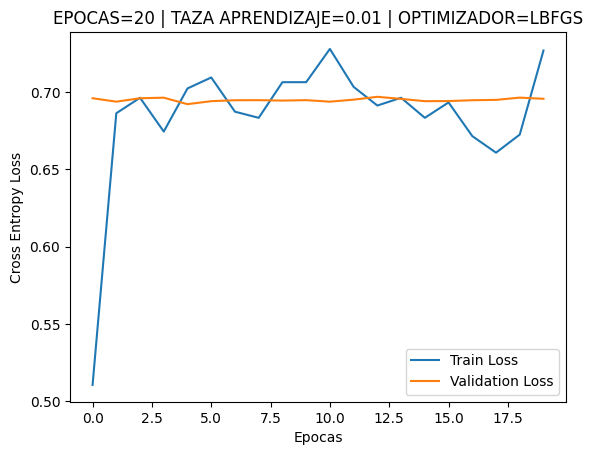

In [87]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.01 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

****************** CHANGING THE LEARNING RATES OF MODELS 0.0001 ******************

EPOCHS=5 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/5]	Training [20%]	Loss: 0.6872
Epoch [1/5]	Validation	Loss: 0.6959	Validation Accuracy: 48.5%
Epoch [2/5]	Training [40%]	Loss: 0.6665
Epoch [2/5]	Validation	Loss: 0.6957	Validation Accuracy: 51.5%
Epoch [3/5]	Training [60%]	Loss: 0.6559
Epoch [3/5]	Validation	Loss: 0.6937	Validation Accuracy: 51.5%
Epoch [4/5]	Training [80%]	Loss: 0.6962
Epoch [4/5]	Validation	Loss: 0.6953	Validation Accuracy: 51.5%
Epoch [5/5]	Training [100%]	Loss: 0.6872
Epoch [5/5]	Validation	Loss: 0.6968	Validation Accuracy: 50.0%
Performance on the test data:
	Loss: 0.6968
	Accuracy: 50.0%
	precision: 50.0%
	recall: 50.0%
	f_score: 38.0%
(0.5, 0.5, 0.37996031746031744, None)

Confusion Matrix:
[[94  6]
 [94  6]]


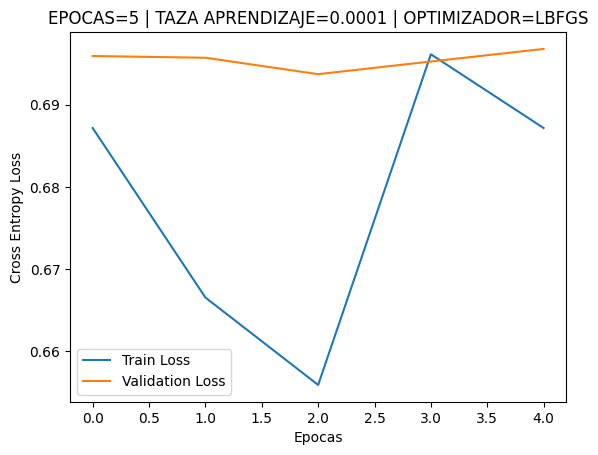

In [88]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=5 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=10 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/10]	Training [10%]	Loss: 0.7226
Epoch [1/10]	Validation	Loss: 0.6911	Validation Accuracy: 52.0%
Epoch [2/10]	Training [20%]	Loss: 0.7144
Epoch [2/10]	Validation	Loss: 0.6894	Validation Accuracy: 55.0%
Epoch [3/10]	Training [30%]	Loss: 0.6982
Epoch [3/10]	Validation	Loss: 0.6941	Validation Accuracy: 48.0%
Epoch [4/10]	Training [40%]	Loss: 0.6892
Epoch [4/10]	Validation	Loss: 0.6908	Validation Accuracy: 52.0%
Epoch [5/10]	Training [50%]	Loss: 0.6921
Epoch [5/10]	Validation	Loss: 0.6920	Validation Accuracy: 52.0%
Epoch [6/10]	Training [60%]	Loss: 0.7113
Epoch [6/10]	Validation	Loss: 0.6895	Validation Accuracy: 57.5%
Epoch [7/10]	Training [70%]	Loss: 0.6773
Epoch [7/10]	Validation	Loss: 0.6911	Validation Accuracy: 55.0%
Epoch [8/10]	Training [80%]	Loss: 0.7072
Epoch [8/10]	Validation	Loss: 0.6918	Validation Accuracy: 51.5%
Epoch [9/10]	Training [90%]	Loss: 0.6972
Epoch [9/10]	Validation	Loss: 0.6922	Validation Accuracy: 49.5%
Epoch [10/10]	Training [100%]	Loss: 0.6962
Epoch [10/10

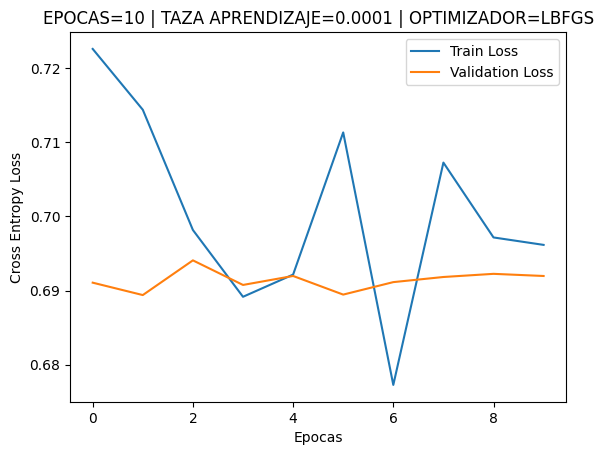

In [89]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=10 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=15 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/15]	Training [7%]	Loss: 0.7298
Epoch [1/15]	Validation	Loss: 0.6936	Validation Accuracy: 48.5%
Epoch [2/15]	Training [13%]	Loss: 0.6792
Epoch [2/15]	Validation	Loss: 0.6911	Validation Accuracy: 52.5%
Epoch [3/15]	Training [20%]	Loss: 0.6802
Epoch [3/15]	Validation	Loss: 0.6918	Validation Accuracy: 51.0%
Epoch [4/15]	Training [27%]	Loss: 0.6685
Epoch [4/15]	Validation	Loss: 0.6917	Validation Accuracy: 53.5%
Epoch [5/15]	Training [33%]	Loss: 0.7032
Epoch [5/15]	Validation	Loss: 0.6917	Validation Accuracy: 52.5%
Epoch [6/15]	Training [40%]	Loss: 0.6992
Epoch [6/15]	Validation	Loss: 0.6915	Validation Accuracy: 53.5%
Epoch [7/15]	Training [47%]	Loss: 0.6911
Epoch [7/15]	Validation	Loss: 0.6919	Validation Accuracy: 53.0%
Epoch [8/15]	Training [53%]	Loss: 0.6921
Epoch [8/15]	Validation	Loss: 0.6926	Validation Accuracy: 53.5%
Epoch [9/15]	Training [60%]	Loss: 0.6921
Epoch [9/15]	Validation	Loss: 0.6917	Validation Accuracy: 53.5%
Epoch [10/15]	Training [67%]	Loss: 0.6951
Epoch [10/15]	

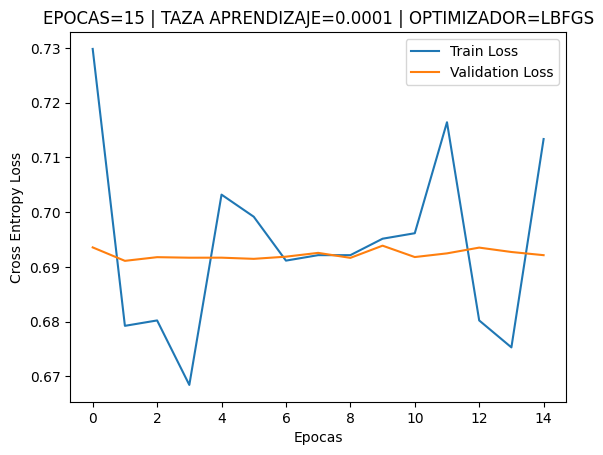

In [90]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=15 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

EPOCHS=20 | LEARNING RATE=0.0001 | OPTIMIZER = LBFGS

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch [1/20]	Training [5%]	Loss: 0.7113
Epoch [1/20]	Validation	Loss: 0.6964	Validation Accuracy: 45.5%
Epoch [2/20]	Training [10%]	Loss: 0.6892
Epoch [2/20]	Validation	Loss: 0.6962	Validation Accuracy: 48.5%
Epoch [3/20]	Training [15%]	Loss: 0.6822
Epoch [3/20]	Validation	Loss: 0.6981	Validation Accuracy: 39.0%
Epoch [4/20]	Training [20%]	Loss: 0.7123
Epoch [4/20]	Validation	Loss: 0.6981	Validation Accuracy: 46.0%
Epoch [5/20]	Training [25%]	Loss: 0.6704
Epoch [5/20]	Validation	Loss: 0.6960	Validation Accuracy: 41.5%
Epoch [6/20]	Training [30%]	Loss: 0.7032
Epoch [6/20]	Validation	Loss: 0.6962	Validation Accuracy: 40.5%
Epoch [7/20]	Training [35%]	Loss: 0.7329
Epoch [7/20]	Validation	Loss: 0.6983	Validation Accuracy: 44.5%
Epoch [8/20]	Training [40%]	Loss: 0.7164
Epoch [8/20]	Validation	Loss: 0.6961	Validation Accuracy: 46.0%
Epoch [9/20]	Training [45%]	Loss: 0.7298
Epoch [9/20]	Validation	Loss: 0.6958	Validation Accuracy: 48.5%
Epoch [10/20]	Training [50%]	Loss: 0.7164
Epoch [10/20]	

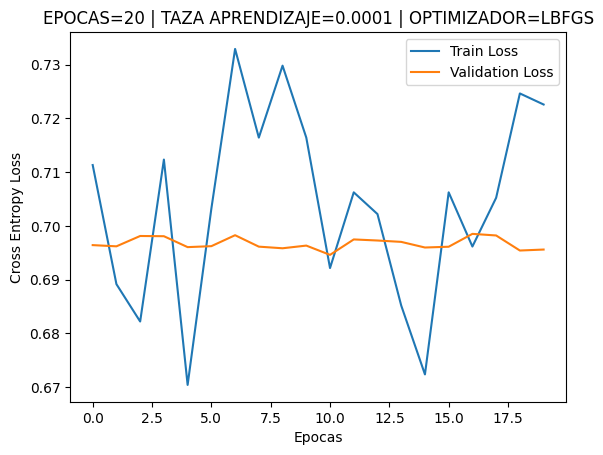

In [91]:
model = Net(num_qubits)
optimizer = optim.LBFGS(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        def closure():
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            return loss

        optimizer.step(closure)
        total_train_loss.append(loss.item())

    avg_train_loss = sum(total_train_loss) / len(total_train_loss)
    train_loss_list.append(avg_train_loss)
    print('Epoch [{}/{}]\tTraining [{:.0f}%]\tLoss: {:.4f}'.format(epoch + 1, epochs,100. * (epoch + 1) / epochs, avg_train_loss))

    # Validation
    model.eval()
    total_val_loss = []
    y_true = []  # Para almacenar las etiquetas verdaderas
    y_pred = []  # Para almacenar las etiquetas predichas
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            loss = loss_func(output, target)
            total_val_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            # Save true and predicted labels for confusion matrix
            y_true.append(target.item())
            y_pred.append(pred.item())

            correct += pred.eq(target.view_as(pred)).sum().item()

        avg_val_loss = sum(total_val_loss) / len(total_val_loss)
        val_loss_list.append(avg_val_loss)
        accuracy = correct / len(test_loader.dataset) * 100
        print('Epoch [{}/{}]\tValidation\tLoss: {:.4f}\tValidation Accuracy: {:.1f}%'.format(epoch + 1, epochs, avg_val_loss, accuracy))
        if(epoch + 1 == epochs):
            print('Performance on the test data:\n\tLoss: {:.4f}'.format(avg_val_loss))
            # Calculo de Presicion, recall, fscore, accuracy
            precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            accuracy = np.mean(np.array(y_true) == np.array(y_pred))
            print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
            print('\tprecision: {:.1f}%'.format(precision * 100))
            print('\trecall: {:.1f}%'.format(recall * 100))
            print('\tf_score: {:.1f}%'.format(f_score * 100))
            print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
            conf_matrix = confusion_matrix(y_true, y_pred)
            print('\nConfusion Matrix:')
            print(conf_matrix)
# Plotting
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('EPOCAS=20 | TAZA APRENDIZAJE=0.0001 | OPTIMIZADOR=LBFGS')
plt.xlabel('Epocas')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

In [92]:
loss.item()

0.6802316781799692

Testing the network

In [93]:
"""Use this method directly - """
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Valor real')
    plt.xlabel('Valor predecido')
    plt.tight_layout()

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

C:\Users\Sergio\AppData\Local\Temp\ipykernel_24812\3141183584.py:35: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Performance on the test data:
	Loss: 0.6957
	Accuracy: 45.0%
	precision: 43.9%
	recall: 45.0%
	f_score: 42.5%
(0.439290917921321, 0.45, 0.42462600690448793, None)
Confusion matrix, without normalization
[[66 34]
 [76 24]]


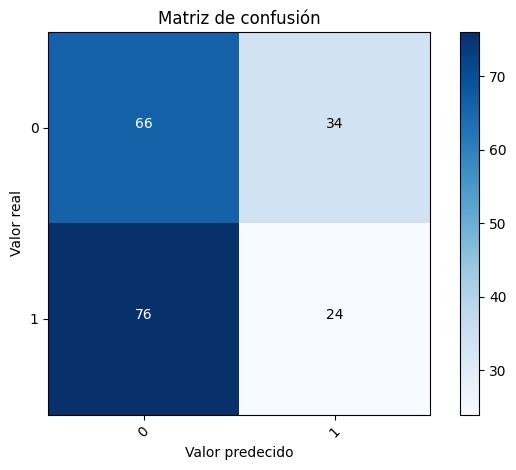

In [95]:
model.eval()

# Lists to store true and predicted labels
y_true = []
y_pred = []

# Lists to store loss values
total_loss = []

# Loop through the test set
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # Forward pass
        output = model(data)

        # Get predicted labels
        pred = output.argmax(dim=1, keepdim=True).view(-1)

        # Save true and predicted labels
        y_true.append(target.item())
        y_pred.append(pred.item())

        # Calculate loss (if needed)
        loss = loss_func(output, target)
        total_loss.append(loss.item())

# Print performance metrics
print('Performance on the test data:\n\tLoss: {:.4f}'.format(sum(total_loss) / len(total_loss)))

precision, recall, f_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
# Calculate and print accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print('\tAccuracy: {:.1f}%'.format(accuracy * 100))
print('\tprecision: {:.1f}%'.format(precision * 100))
print('\trecall: {:.1f}%'.format(recall * 100))
print('\tf_score: {:.1f}%'.format(f_score * 100))
print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
# Create and visualize the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_matrix, [0,1],normalize=False,title='Matriz de confusión',cmap=plt.cm.Blues)


In [96]:
print("acabo")

acabo


: 